# DATA PREPROCESSSING AND VARIABLE GENERATION
-------
**Author:** <span style="color:blue">Dunstan Matekenya</span>

In this notebook, the main goal is to generate matching variables in the 2018 census hereinafter referred to as ```census``` 
and the ```ENQUETE PERMANENTE AUPRES DES MENAGES 2021-2022 (EPM21-22)```  hereinafter referred to as ```EPM```. In particular, the following key steps are performed:
- Prepare the datasets and perform initial clean up such as dropping invalid observations
- Generate matching variables across specific themes
- Output two datasets with matching variables

# Setup Python environment
-----

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import math
import scipy.stats as st
from scipy.stats import ks_2samp, ttest_ind

# Spark for processing census data
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import pandas_udf, udf, col, broadcast
from pyspark.sql.types import IntegerType, StringType

import os
from pathlib import Path
import shutil
import re
from datetime import datetime, date
from dateutil.relativedelta import *

from IPython.display import Image,  HTML, display
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Suppress scientific nottation outputs in pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
start = datetime.now()
print('Starting processing at: {} '.format(start.ctime()))

Starting processing at: Mon Mar 20 15:12:13 2023 


# Setup input parameters and variables
---

## Setup input data folders
All the input data used in this notebook are available in this [OneDrive folder](https://worldbankgroup-my.sharepoint.com/:f:/r/personal/dmatekenya_worldbankgroup_org/Documents/MAD-POV-ESTIMATION/data/input?csf=1&web=1&e=WGeba4). If you would like to replicate this analysis, please see details and notes below.

### Data sources, access and availability 
All the census  datasets were receivd as SPSS files (`.sav`) and they were convertd to CSV using SPSS software or Python. For the EPM survey, the data is in STATA file format (`.dta`) and they are being read in pandas as is.
1. **INSTAT_BD_SPSS_HOUSEHOLDS_10pc_RGPH-3_2018.csv**. This is a census household level dataset covering 10% of the whple ceensus data. This is an open dataset and it can be downloaded from the (National Institute of Statistics of Madagascar-INSTAT](https://www.instat.mg) website or [WBG microdata library](https://microdata.worldbank.org/index.php/home).
2. **INSTAT_BD_SPSS_RESIDENTS_10pc_RGPH-3_2018.csv** Similar to the dataset mentioned above, this is an individual level census dataset covering 10% of the census. It can be downloaded from [INSTAT](https://www.instat.mg) website or [WBG microdata library](https://microdata.worldbank.org/index.php/home).
3. **MenageOrdinaireIBEIPM.csv**. This is the full household level census dataset. As expected, access to this dataset is restricted. However, WBG staff can contact `Francis Muamba Mulangu` to request access. 
4. **ResidentIBEIPM.csv** This is the full individual level census dataset. As expected, access to this dataset is restricted. However, WBG staff can contact `Francis Muamba Mulangu` to request access. 
5. **ResidentIBEIPM-pov.csv** This dataset was derived from **ResidentIBEIPM.csv** by dropping the columns we dont need for this analyisis. For deetails on how this data was generated, see the function `downsample_census_dataset()`.
6. **ResidentIBEIPM-pov-preprocessed.csv**. In order to expedite testing and aanalysis, the dataset above (**ResidentIBEIPM-pov.csv**) was processed to remove duplicates, drop large (non-regular households) and the result saved to this current file. FOr details on what preprocessing was done, see `spark_prep_census_dataset()`
7. **ResidentIBEIPM-pov-preprocessed-HoH.csv**. Since we mostly work with data for household heads only, for convinience, this dataset was generated from **ResidentIBEIPM-pov-preprocessed.csv** by keeping only heads of household observations.
8. **geographic-region-names.csv**. This data file was manually creeted from [census dataset metadata document](https://worldbankgroup-my.sharepoint.com/:b:/r/personal/dmatekenya_worldbankgroup_org/Documents/MAD-POV-ESTIMATION/docs/census-metadata.pdf?csf=1&web=1&e=B5849n) which provides geographic regions names and their codes used in census data. This file was used in tandem with **Couverture2G_3G_4G.shp** and **GpsGrappes.xlsx** to generate the following files (see `get_geo_codes_epm()` for details on how this was done):
    - **census-dist-codes.csv** Provides province, region and district names and codes
    - **epm-dist-codes.csv** Associates survey clusters with their corresponding province, region and district names and codes
9. **EPM data files**. All the survey data files are organized by modules and are in one folder named `epm21/data-files`. In order to get access to this data, please check the [WBG microdata library](https://microdata.worldbank.org/index.php/home). If this data is not yet available, please contact `Alexandra Jarotschkin` for access. For specific EPM files, see below:
    - **ca_real.dta**. This is the data file with the target variable (consumption). 
    - **FIC_POND_EPM21.xlsx**. This file has the survey weights.
    - **GpsGrappes.xlsx**. For all sampled clusters in the survey, this file provides their cluster centroids GPS coordinates.

In [4]:
# If one needs to replicate this processing, 
# the directtories below can be replaced with absolute paths
DIR_DATA = Path.cwd().parents[0].joinpath("data")
DIR_OUTPUT = DIR_DATA.joinpath("derived")

# DHS input files
DIR_DHS_DATA = DIR_DATA.joinpath("input", "dhs-21")
FILE_CHILD = DIR_DHS_DATA.joinpath('MDKR81DT_Children', 'MDKR81FL.DTA')
FILE_HH = DIR_DHS_DATA.joinpath('MDHR81DT_Household','MDHR81FL.DTA')
FILE_HH_MEMBERS = DIR_DHS_DATA.joinpath('MDPR81DT_HHMember','MDPR81FL.DTA')

# FILE_SURVEY_WEIGHTS = DIR_EPM_DATA.joinpath('FIC_POND_EPM21.xlsx')
# FILE_CLUSTER_COORDS = DIR_DATA.joinpath("input", "geography", "GpsGrappes.xlsx")

# census input files
DIR_CENSUS = DIR_DATA.joinpath("input", "census", "data")
FILE_CENSUS_HH = DIR_CENSUS.joinpath("INSTAT_BD_SPSS_HOUSEHOLDS_10pc_RGPH-3_2018.csv")
FILE_CENSUS_HH_FULL = DIR_CENSUS.joinpath("MenageOrdinaireIBEIPM.csv")
FILE_CENSUS_PERSONS = DIR_CENSUS.joinpath("INSTAT_BD_SPSS_RESIDENTS_10pc_RGPH-3_2018.csv")
FILE_CENSUS_PERSONS_FULL = DIR_CENSUS.joinpath("ResidentIBEIPM.csv")
FILE_CENSUS_PERSONS_FULL_COLS_SUBSET = DIR_CENSUS.joinpath("ResidentIBEIPM-pov.csv")
FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED = DIR_CENSUS.joinpath("ResidentIBEIPM-pov-preprocessed.csv")
FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED_HOH = DIR_CENSUS.joinpath("ResidentIBEIPM-pov-preprocessed-HoH.csv")
FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED_CHILD = DIR_CENSUS.joinpath("ResidentIBEIPM-pov-preprocessed-child.csv")
FILE_CENSUS_GEO_CODE_NAME_MATCH = DIR_CENSUS.joinpath("geographic-region-names.csv")


# Geography files
FILE_CENSUS_COMMUNES_SHP = DIR_DATA.joinpath("input/geography/census-communes/Couverture2G_3G_4G.shp")
# Displaced cluster centroids, accurate within district
FILE_DHS_CLUSTER_CENTROIDS_SHP = DIR_DATA.joinpath("input/geography/MDGE81FL.shp")

# generated using this function: get_geo_codes_epm()
FILE_CENSUS_DIST_CODES = DIR_DATA.joinpath("input/geography/census-dist-codes.csv")
FILE_DHS_DIST_CODES = DIR_DATA.joinpath("input/geography/dhs-dist-codes.csv")
FILE_DIST_CODES_SHP = DIR_DATA.joinpath("input/geography/dist-codes.shp")

# emporary file to hold age-specific HH size
# because it takes too long to proces
FILE_CENSUS_CHILD_DEP_RATIO = DIR_CENSUS.joinpath("child-dependency-ratio.csv")

## Define global variables

In [5]:
# Rename columns and use labels as column names 
# the labels were copied from the STATA do file: MDKR81FL.DO
VAR_RENAMING_CHILD = {'v001': 'cluster', 'v002': 'hh_num','v003':'resp_line_num',
                'v012': 'resp_age', 'v106': 'high_educ_level', 'v107': 'high_yr_educ',
                'v133': 'educ_single_yrs', 'v136': 'num_hh_members', 'v137': 'num_child_u5',
                'v149':'educ_attainment', 'v150': 'rel_HoH', 'v151': 'sex_HoH', 'v152': 'age_HoH',
                'v153': 'telephone', 'v024': 'region', 'v025': 'urb_rural', 'v021':'PSU',
                'v005': 'hh_weight', 'b19': 'chd_age_months', 'b8': 'chd_age','v155': 'literacy',
                'v161': 'cooking_fuel','v169a': 'mobilephone', 'v171a': 'use_internet', 
                'v170': 'bank_acc','b5': 'chd_alive', 'b3':'dob_cmc', 'b1': 'dob_month', 'b2': 'dob_yr',
                'hw1': 'chd_age_months2', 'hw2': 'wgt_kg', 'hw3': 'height_cm', 'v006': 'doi_month', 
                'v007':'doi_yr', 'v008':'doi_cmc','b9':'chd_lives_with', 'b16':'chd_line_num',
                'hw4': 'height_age_perc', 'hw5': 'height_age_std', 'hw7': 'weight_age_perc', 
                'hw8': 'weight_age_std', 'hw11': 'weight_height_std', 'hw13': 'result_measurement',
                'hw15': 'height_lying_standing', 'hw70': 'height_age_std_WHO', 
                'hw71': 'weight_age_std_WHO', 'hw72': 'weight_height_WHO','hw73': 'BMI_std_WHO',
                'b4': 'chd_sex', 'v004':'area_unit'}

# Refer to page-15 and onwards in the Recode manual
VAR_RENAMING_HH_MM = {'hv001': 'cluster', 'hv101': 'rel_HoH', 'hvidx': 'person_line_num',
                   'hv002': 'hh_num', 'hv004': 'area', 'hv120': 'chd_elig_anth','hv103':'slept_last_night',
                   'hv115': 'marital_status', 'hv104': 'sex', 'hc3': 'chd_height','hc2':'chd_weight',
                   'hc5': 'height_age_std','hv025': 'urban_rural',
                     'sh121k': 'sewing_machine', 'sh121l': 'AC_fan','hc70': 'height_age_std_WHO',
                     'sh121m': 'video_player', 'hv105': 'age', 'hc61': 'mother_high_educ_lev',
                     'hv106': 'highest_educ_lev_attained', 'hml16a':'chd_age_months2',
                     'hv107': 'highest_educ_yr_comp','hv121':'current_in_sch',
                      'hv108':'educ_comp_single_yrs', 'hv122':'educ_lev_current', 'hv109': 'eeduc_attainment',
                     'hv111': 'mother_alive', 'hv116':'never_married', 'hv035':'num_chd_elig_anth',
                      'hv110':'NA_still_in_sch','sh16': 'ever_attended_sch',
                      'sh17': 'educ_attainment', 'sh17a': "lev_educ_attended", 'hc1a':'chd_age_dys',
                      'sh17b':"highest_grade comp", 'sh19a':'lev_attending', 'hv114': 'father_line_num',
                      'sh19b':"grade_attending",'hc1':'chd_age_months', 'hv112': 'mother_line_num',
                      'hv113': "father_alive", 'hv005': 'hh_weight', 'hv226':'cooking_fuel', 
                     'hv201': 'drink_water', 'hv204':'time_water', 'hv205': 'toilet_type',
                'hv206':'electricity', 'hv207': 'radio', 'hv208': 'TV',  'hv221': 'telephone', 
                      'hv243a':'mobilephone', 'hv243e':'computer',
                'hv209': 'refrigerator', 'hv210': 'bicycle', 'hv211': 'motorcycle_scooter',
                'hv212':'car', 'hv213': 'floor', 'hv214': 'wall', 'hv215': 'roof'}

# For efficiency, load only columns we need
CENSUS_COLS = list(set(['PROVINCE', 'REGION', 'DISTRICT', 'COMMUNES', 'MILIEU', 'IDINDIV','IDMEN', 
               'H17N$1','H02$1','H17D$1','H17F$1','H17L$1','P04','C11',
               'P05','P25','H13$1','H16$1','P07M','P01','H17C$1','P08','P20FR',
               'H06$1','H04$1','P07A','P22C','H01$1','H05$1','H17H$1','H17I$1','H17M$1',
                'P19MG','P26C','H09$1','P06','H14$1','H10$1','P09D','P28','P14A_3', 'P15', 'P16', 'P17', 'P18',
                'H17B$1','P23','P24C','H17A$1','H11$1','H15$1','H17O$1','H17G$1','P22N',
                'P21','H17E$1','H07$1','H03$1','H08$1','P03','P09C','H17J$1','H12$1',
                'H17K$1','P12C']))


# whether to drop children not living in household
DROP_CHILD_OUTSIDE_HH = True

# Household Sample weight
# DHS sample weighting info available here:
# https://dhsprogram.com/data/Using-DataSets-for-Analysis.cfm#CP_JUMP_14042
HH_WEIGHT = 'hh_weight'

# Whether to run function to
# Code for not applicable (for instance, if the question only applies to 3 years+)
NOT_APPLICABLE = 9999

# census date for age calculation
CENSUS_NIGHT = date(2018, 6, 25)

# Household ID varss
CENSUS_HHID = 'IDMEN'
DHS_HHID = 'hh_id'

# unique person identifier
PID = 'person_id'

# Head of HH
CENSUS_HOH = 'P03'
EPM_HOH = 'q1_02'
HH_HEAD = 'HoH'

# whether we use only Head of HHs or all HH residents
USE_HH_HEAD_ONLY = True

# For assets, set NaN to dont have
ASSETS_SET_NAN_TO_ZERO = True

# Maximum allowabele age
MAX_AGE = 120

# ==================================
# CONSTANTS FOR QUALITY CHECKS
# ==================================
# number of HHs
DHS_NUM_HHS = 20510

# Number of children with valid height-age ratio
# and other anthropometric data based 
# on DHS report (page 230-231)
DHS_NUM_CHILDREN = 6335

# Largest HH size
DHS_LARGEST_HH_SIZE = 22

# Proportion of children studented
# as reported in DHS report (page 216)
DHS_PROP_STUNTED = 0.4

# List to hold dataframes with generated variables
# These dataframes will later bee merged to create final datasete
CENSUS_HH_VARS = {}
CENSUS_CHILD_VARS = {}
DHS_HH_VARS = {}
DHS_CHILD_VARS = {}

# whetheer to drop reference colum during one-hot encoding
ONE_HOT_ENCODING_DROP_FIRST = True

# which geographic regions to add as variables
GEOGRAPHIC_REGION_VARS = ['prov_code']

In [6]:
def weighted_avg_and_std(df, value, weight='weight'):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    if sum(df[value].isna()*1) > 0:
        print('EPM weighted stats, found {} null values in {}'.format(sum(df[value].isna()*1), value))
        df.dropna(subset=[value], inplace=True)
    average = np.average(df[value].values, weights=df[weight].values)
    # Fast and numerically precise:
    variance = np.average((df[value].values-average)**2, weights=df[weight].values)
    return (average, math.sqrt(variance))

# Prepare data for variable generation
----

In [137]:
def prep_geography():
    """
    DHS data has cluster IDs without corresponding province, region, district and commune ID.
    Use DHS provide clucter centroids to find corresponding district code.
    """
    # =======================================================
    # LOAD EPM CLUSTER CENTROIDS AND CONVERT TO GEODATAFRAME
    # =======================================================
    gdf_coords = gpd.read_file(FILE_DHS_CLUSTER_CENTROIDS_SHP)
    
    # =======================================================
    # LOAD CENSUS COMMUNES(ADM4) AND FIX DIST-ID ISSUE
    # =======================================================
    gdf_adm4 = gpd.read_file(FILE_CENSUS_COMMUNES_SHP)
    gdf_adm4 = gdf_adm4.to_crs("EPSG:4326")
    gdf_dist = gdf_adm4.dissolve(by="D_CODE")
    gdf_dist["D_CODE"] = gdf_dist.index
    gdf_dist.reset_index(drop=True, inplace=True)
    
    # =======================================================
    # JOIN CLUSTER CENTROIDS WITH COMMUNES
    # =======================================================
    df = gpd.sjoin(left_df=gdf_dist, right_df=gdf_coords, how='inner', predicate='contains')
    assert df.shape[0] == len(gdf_coords)    

    keep_cols = ['REGION', 'R_CODE', 'DISTRICT', 'D_CODE', 'COMMUNE', 'C_CODE', 'DHSCLUST', 'geometry']
    df_epm = df[keep_cols]
    df_epm.rename(columns={'REGION':'region', 'R_CODE':'reg_code', 'DISTRICT':'district', 'D_CODE':'dist_code',
                       'COMMUNE':'commune', 'C_CODE':'comm_code'},inplace=True)
    

    # =======================================================
    # CHECK IF ALL EPM COMMUNES HAVE MATCHES IN CENSUS USING
    # WHOLE CENSUS DATASET
    # =======================================================    
    # Get dataframe which has census pop geo codes
    # and names
    dfc_doc_all = pd.read_csv(FILE_CENSUS_GEO_CODE_NAME_MATCH)
    dfc_doc = dfc_doc_all.query('`admin-level` == "district"')
    
    # Just to be sure, lets merge with whats actually in the 
    # census data file
    df_HoH = pd.read_csv(FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED_HOH)
    dfc_actual = df_HoH.drop_duplicates(subset=['DISTRICT'])[['PROVINCE', 'REGION', 'DISTRICT']]
    
    dfc = dfc_actual.merge(dfc_doc, left_on='DISTRICT', right_on='code', indicator=True)
    assert dfc._merge.value_counts()['both'] == len(dfc_actual)
    dfc.drop(columns=['_merge'], inplace=True)
    dfc['code'] = dfc.code.astype(str)
    
    
    
    # this is done after checking that onlly one name didnt match
    df_epm['district'] = df_epm['district'].replace('Port-Berge (Boriziny-Vaovao)', 'PORT-BERGE(BORIZINY-VAOVAO)')
    dfc['name'] = dfc['name'].apply(lambda x: x.strip().lower().replace(" ", "-"))
    df_epm['district'] = df_epm['district'].apply(lambda x: x.strip().lower().replace(" ", "-"))
    df_epm_dist = df_epm.drop_duplicates(subset=['dist_code'])
    
    df_name_matched = dfc.merge(df_epm_dist, left_on='name', right_on='district', how='left', indicator=True)
    assert df_name_matched._merge.value_counts()['both'] == len(df_epm_dist)
    df = df_name_matched.drop(columns=['_merge'])
    
    
    # We can drop all the bad codes from census shapefile
    df.drop(columns=['region', 'reg_code', 'district', 'dist_code', 'commune', 'comm_code', 'admin-level', 'code'], inplace=True)
    df.rename(columns={'PROVINCE':'prov_code', 'REGION':'reg_code', 'DISTRICT':'dist_code', 'name':'district'},  inplace=True)
    
    # =======================================================
    # ADD PROVINCE AND REGION NAMES FOR THE SAKE OF CENSUS
    # =======================================================    
    region_name = dfc_doc_all.query('`admin-level` == "region"')
    prov_name = dfc_doc_all.query('`admin-level` == "province"')

    df_reg = df.merge(region_name, left_on='reg_code', right_on='code', indicator=True)
    assert df_reg._merge.value_counts()['both'] == len(df)
    df_reg.drop(columns=['_merge', 'code', 	'admin-level'], inplace=True)
    df_reg.rename(columns={'name': 'region'}, inplace=True)

    df_prov = df.merge(prov_name, left_on='prov_code', right_on='code', indicator=True)
    assert df_prov._merge.value_counts()['both'] == len(df)
    df_prov.rename(columns={'name': 'province'}, inplace=True)

    df2 = df_reg.merge(df_prov[['dist_code', 'province']], on='dist_code', indicator=True)
    assert df2._merge.value_counts()['both'] == len(df2)

    df_census = df2[['province', 'prov_code', 'region', 'reg_code', 'district', 'dist_code']]
    gdf_census = gpd.GeoDataFrame(df2[['province', 'prov_code', 'region', 'reg_code', 'district', 'dist_code', 'geometry']])
    
    
    # =======================================================
    # NOW, BRING BACK ALL EPM CLUSTERS
    # ======================================================= 
    df_epm2 = df_epm[['district', 'DHSCLUST']].merge(df_census, on='district', indicator=True)
    assert df_epm2._merge.value_counts()['both'] == len(df_epm)
    df_epm2.drop(columns=['_merge'], inplace=True)
    df_epm = df_epm2[['province', 'prov_code', 'region', 'reg_code',
       'district', 'dist_code', 'DHSCLUST']]
    df_epm.rename(columns={'DHSCLUST':'cluster'}, inplace=True)
    
    # =============================================
    # RUN SOME CHECKS
    # =============================================
    assert sorted(dhs.prov_code.value_counts().index) == sorted(dfc.prov_code.value_counts().index)
    assert sorted(dhs.reg_code.value_counts().index) == sorted(dfc.reg_code.value_counts().index)
    
    try:
        assert sorted(dhs.dist_code.value_counts().index) == sorted(dfc.dist_code.value_counts().index)
    except:
        dist_list = list(set(dfc.dist_code.value_counts().index) - set(dhs.dist_code.value_counts().index))
        print('{} districts in census not in DHS'.format(len(dist_list)))
    
        
    # =======================================================
    # SAVE THE FILES
    # =======================================================
    # for DHS
    df_epm.to_csv(FILE_DHS_DIST_CODES,index=False)
    
    # for census
    df_census.to_csv(FILE_CENSUS_DIST_CODES,index=False)
    
    # save shapefile
    gdf_census.dropna(subset=['geometry'], inplace=True)
    gdf_census.to_file(FILE_DIST_CODES_SHP, driver='ESRI Shapefile')
    outjson = DIR_DATA.joinpath("input/geography/dist-codes.json")
    gdf_census.to_file(outjson, driver="GeoJSON")

In [8]:
def downsample_census_dataset(keep_cols):
    """
    The full census dataset is 16GB after conversion from SPSS. However, 
    some of the columns are not needed in this work, so we remove those 
    columns and keep those we need using spark.
    """
    # Create Spark session
    appName = "Downsample census data"
    master = "local[*]"
    
    spark = SparkSession.builder \
        .appName(appName) \
        .master(master) \
        .getOrCreate()
    # Load the data
    sdf = spark.read.csv(str(FILE_CENSUS_PERSONS_FULL), header=True)
    
    # get number of columns for verification
    num_rows_before = sdf.count()
    
    # Keep the columns we need 
    sdf2 = sdf.select(keep_cols)
    
    # Repartition and save
    tmp_out_folder = DIR_DATA.joinpath('tmp.csv')
    sdf2.repartition(10).coalesce(1).write.csv(str(tmp_out_folder), header=True)
    
    # Move it to census data folder
    for file in tmp_out_folder.iterdir():
        if file.suffix == ".csv":
            shutil.move(file, FILE_CENSUS_PERSONS_FULL_COLS_SUBSET)
    
    # clean up by removing the spark output folder
    shutil.rmtree(tmp_out_folder)
    
    # Lets load the file and verify that there are no
    # rows lost
    sdf = spark.read.csv(str(FILE_CENSUS_PERSONS_FULL_COLS_SUBSET), header=True)
    assert num_rows_before == sdf.count()
    print('SUCCESSFULLY SAVED THE DATA')
    
    spark.stop()

In [9]:
def add_var_census_age_from_dob(row):
    """
    Add age from DOB to use to impute age when its missing 
    """
    birth_month = row['P07M']
    birth_year = row['P07A']
    if birth_month == 98 or birth_month == 99:
        birth_month = 1
    if birth_year == 9998:
        return 9998
    if birth_year < 1910:
        return 9998
    
    dob = date(birth_year, birth_month, 1)
    age = relativedelta(CENSUS_NIGHT, dob)
    
    return age.years

In [10]:
def convert_age_to_num(row):
    """
    'P08' (age) is loaded as a string because it has some null values, here, 
    we just convert to numeric and replace those nulls with NaN
    """
    # age_from_dob = row['calc_age']
    age_str = row['P08']
    try:
        age = int(age_str)
        return age
    except:
        return np.nan

In [11]:
def gen_var_dhs_hh_size(df_indiv, hh_id_col):
    """
    Add number of persons per HH.
    For census, we will use only regular HHs if info is available. 
    If not, we will filter out non-regular HHs.
    """
    
    # ======================================================
    # GENERATE HH SIZE FOR DHS
    # ======================================================
    df_grp = df_indiv.groupby(hh_id_col).size().reset_index()
    df_grp.rename(columns={0:'hh_size'}, inplace=True)
    max_hh_size = df_grp['hh_size'].max()
    print('Largest HH size in the survey to use as max in census: {}'.format(max_hh_size))
    
    # Add index for easieer merging later
    df_grp.set_index(DHS_HHID, inplace=True)

    return df_grp, max_hh_size

In [12]:
def spark_save_census_HoH_data(input_preprocessed_indiv_data):
    """
    Given preprocessed data, keep only Household heads (HoH) for easier upload
    """
    # Load the data
    appName = "Downsample census data"
    master = "local[*]"
    spark = SparkSession.builder \
                .appName(appName) \
                .master(master) \
                .getOrCreate()
    
    df_persons = spark.read.csv(str(input_preprocessed_indiv_data), header=True).repartition(10)
    dfc_HoH = df_persons.filter('{} == 0'.format(CENSUS_HOH))
    
    # Repartition and save
    tmp_out_folder = DIR_DATA.joinpath('tmp.csv')
    dfc_HoH.repartition(10).coalesce(1).write.csv(str(tmp_out_folder), header=True)
        
    # Move it to census data folder
    for file in tmp_out_folder.iterdir():
        if file.suffix == ".csv":
            shutil.move(file, FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED_HOH)
    
    # Delete tmp folder
    shutil.rmtree(tmp_out_folder)

In [13]:
def spark_prep_census_indiv_dataset(have_hh_type=False,  max_hh_size=19):
    """
    1. Merge HH data with persons data and drop any persons without HHs
    2. Drop any invalid observations (e.g., with no age or invalid age, no HH head)
    3. Drop non-regular HHs
    """
    # ================================
    # LOAD THE DATASETS
    # ================================
    # Create Spark session
    appName = "Downsample census data"
    master = "local[*]"
    
    spark = SparkSession.builder \
                .appName(appName) \
                .master(master) \
                .getOrCreate()
    
    # Load the data
    
    df_persons = spark.read.csv(str(FILE_CENSUS_PERSONS_FULL_COLS_SUBSET), header=True).repartition(10)
    num_persons = df_persons.count()
    df_hh =spark.read.csv(str(FILE_CENSUS_HH_FULL), header=True).repartition(10)
    num_hhs = df_hh.count()
    print('STARTING WITH {:,} HOUSEHOLDS AND {:,} PERSONS'.format(num_hhs, num_persons))
    
    # ================================
    # MERGE HH DATA WITH PERSONS DATA
    # ================================
    # remove columns we have in thee persons dataset
    to_keep = ['IDMEN']
    df_hh2 = df_hh.select(to_keep)

    # merge
    df_census = df_persons.join(df_hh2, on='IDMEN', how='inner')

    print()
    print('DROPPED {} ROWS WITH NO HH MATCHES'.format(num_persons-df_census.count()))
    
    # ================================
    # ADD GEOGRAPHIC REGION NAMES
    # ================================
    # sdf_geo_names = spark.read.csv(str(FILE_CENSUS_GEO_CODE_NAME_MATCH), header=True)
    # df_census = df_census1.join(df_hh2, on='IDMEN', how='inner')
    
    # =================================================
    # DEAL WITH AGE AND ADD SEX WHILE WE ARE AT IT
    # =================================================
    # connvert age to numeric
    df_census2 = df_census.withColumn('age', col("P08").cast(IntegerType()))
    # add sex
    df_census3 = df_census2.withColumnRenamed('P05', 'sex').withColumnRenamed('MILIEU', 'urban_rural')
    
    # =======================================================
    # DROP NULL/AND INVALID OBSERVATIONS AND NON-REGULAR HHS
    # (NULLL AGE, NEGATIVEE AGE, LARGE AGE, NO HH-HEAD) 
    # =====================================================
    df_drop = df_census3.filter((col('age').isNull()) | (col('P03').isNull()) | (col('age') < 0) | (col('age')> MAX_AGE))
    df_keep = df_census3.exceptAll(df_drop)
    
    # Save dropped observations
    pdf_drop = df_drop.toPandas()
    out_csv = DIR_OUTPUT.joinpath("census_dropped_observations_age.csv")
    pdf_drop.to_csv(out_csv, index=False)

    print('DROPPED {} ROWS DUE TO BAD AGE AND RELATIONSHIP TO HH HEAD'.format(pdf_drop.shape[0]))
    print('DROPPED OBSERVATIONS HAVE BEEN SAVED TO: {}'.format(out_csv))
    print('SO, WILL USE {:,} OBSERVATIONS OUT OF {:,}'.format(num_persons-len(pdf_drop), num_persons))
    
    # ======================================================
    # GET HH SIZE
    # =====================================================
    hh_id = 'IDMEN'
    
    df_census_grp = df_keep.groupBy(hh_id).count().withColumnRenamed('count', 'hh_size')
    dfc_out = df_keep.join(df_census_grp, on=hh_id, how='left')
    
    if have_hh_type:
         # use column C11 to pick only regular HHs (value 0)
        # save the observations being dropped to CSV file
        df_drop = dfc_out.filter(col('C11') != '0').toPandas()
        out_csv = DIR_OUTPUT.joinpath('census-non-regular-hhs.csv')
        df_drop.to_csv(out_csv, index=False)
        
        # keep only those observations with required hh size for the
        # hh_size variable
        dfc_out2 =  dfc_out.filter(col('C11') == '0')
        print('DROPPED {} HOUSEHOLDS NON-REGULAR HOUSEHOLDS'.format(len(df_drop)))
        print('DROPPED OBSERVATIONS SAVED TO: {}'.format(out_csv.parts[-1]))
        
        # Repartition and save
        tmp_out_folder = DIR_DATA.joinpath('tmp.csv')
        dfc_out2.coalesce(1).write.csv(str(tmp_out_folder), header=True)
        
        # Move it to census data folder
        for file in tmp_out_folder.iterdir():
            if file.suffix == ".csv":
                shutil.move(file, FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED)
        
    else:
        # save the observations being dropped to CSV file
        df_drop = dfc_out.filter(col('hh_size') > max_hh_size).toPandas()
        out_csv = DIR_OUTPUT.joinpath('census-dropped-large-hhs.csv')
        df_drop.to_csv(out_csv, index=False)
        
        # keep only those observations with required hh size for the
        # hh_size variable
        dfc_out2 =  dfc_out.filter(col('hh_size') <= max_hh_size)
        print('DROPPED {} HOUSEHOLDS WITH MORE THAN {} MEMBERS'.format(len(df_drop), max_hh_size))
        print('DROPPED OBSERVATIONS SAVED TO: {}'.format(out_csv.parts[-1]))
        
        # Repartition and save
        tmp_out_folder = DIR_DATA.joinpath('tmp.csv')
        dfc_out2.coalesce(1).write.csv(str(tmp_out_folder), header=True)
        
        # Move it to census data folder
        for file in tmp_out_folder.iterdir():
            if file.suffix == ".csv":
                shutil.move(file, FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED)
    
    # Remove temp folder
    shutil.rmtree(tmp_out_folder)

In [14]:
def load_census_data():
    """
    Helper file for tidier loading of census data files.
    """
    # Create Spark session
    appName = "Downsample census data"
    master = "local[*]"
    spark = SparkSession.builder \
                    .appName(appName) \
                    .master(master) \
                    .getOrCreate()
        
    # ======================================
    # LOAD ALL PERSONS CENSUS PREPROCESSED 
    # DATA INTO  SPARK DATAFRAME
    # =====================================
    if FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED.exists():
        # Load the already processed census data file
        sdf_census = spark.read.csv(str(FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED), 
                                    header=True)
    else:
        # Generate this file from 
        spark_prep_census_indiv_dataset(have_hh_type=True,  max_hh_size=DHS_LARGEST_HH_SIZE)
        
        # Load the already processed census data file
        sdf_census = spark.read.csv(str(FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED), 
                                    header=True)
    # ===================================
    # LOAD HoH CENSUS FILE INTO 
    # PANDAS DATAFRAME
    # ===================================
    if FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED_HOH.exists():
        # Load the already processed HoH census data file
        df_HoH = pd.read_csv(FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED_HOH)
    else:
        # generate the file 
        spark_save_census_HoH_data(FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED)
        
        # Now load the file
        df_HoH = pd.read_csv(FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED_HOH)
        
    # ===================================
    # ADD GEO-CODES TO HoH DATAFRAME
    # ===================================
    dfc = pd.read_csv(FILE_CENSUS_DIST_CODES)
    df_HoH2 = df_HoH.merge(dfc, left_on='DISTRICT', right_on='dist_code', indicator=True)
    assert df_HoH2._merge.value_counts()['both'] == len(df_HoH)
    df_HoH2.drop(columns=['_merge'], inplace=True)
        
    print()
    print("="*60)
    print('CHECKING FOR DUPLICATES BASED ON HH-ID')
    print("="*60)
    try:
        assert df_HoH2['IDMEN'].nunique() ==  len(df_HoH2)
        print()
        print('No duplicatess found')
    except:
        print('Check one of the files for duplicates')
    
    # ================================
    # GET CENSUS DATA FOR CHILDREN AND
    # POST PROCESS
    # ===============================
    df_children = get_children_data_from_census(sdf_census_persons=sdf_census)
    print(len(df_children))

    # keep only those households with children
    df_HoH_with_children = df_children.drop_duplicates(subset=[CENSUS_HHID])[[CENSUS_HHID]]
    df_HoH_child  = df_HoH2.merge(df_HoH_with_children, on=CENSUS_HHID, how='inner')
    print('Found {} households with children'.format(len(df_HoH_child)))
    assert len(df_HoH_child) == len(df_HoH_with_children)

    # Do the same for census persons spark dataframe
    sdf_HoH_with_children = spark.createDataFrame(df_HoH_with_children)
    sdf_census_children = sdf_census.join(broadcast(sdf_HoH_with_children), on=CENSUS_HHID, how='inner')
    cnt = sdf_census_children.count()
    print('Found {} persons living in HHs with children'.format(cnt))
    print('Finished loading census data')
    
    return  sdf_census, sdf_census_children, df_HoH2, df_HoH_child, df_children

In [15]:
def prepare_dhs_data(childrenn_use_slept_last_night):
    """
    Prepare DHS data files for processing
    """
    
    # Load the data 
    df_child = pd.read_stata(FILE_CHILD, iterator=False, convert_categoricals=False)
    df_hh_mm = pd.read_stata(FILE_HH_MEMBERS, iterator=False, convert_categoricals=False)
    
    # =====================================
    # PREP HH-MEMBERS DATA FILE TO USE AS 
    # HH-LEVEL DATA
    # =====================================
    # keep only the columns we need
    keep_cols_hh_mm = list(VAR_RENAMING_HH_MM)
    df_hh_mm = df_hh_mm[keep_cols_hh_mm]
    # Rename the columns now
    df_hh_mm.rename(columns=VAR_RENAMING_HH_MM, inplace=True)
    
    # add new hh_id
    df_hh_mm['hh_id'] = df_hh_mm.apply(
        lambda x: str(x['cluster']).zfill(3) + str(x['hh_num']).zfill(3), axis=1)
    

    # individual ID
    df_hh_mm['person_id'] = df_hh_mm.apply(
        lambda x: x['hh_id']+ str(int(x['person_line_num'])).zfill(3), axis=1)
    
    # =====================================
    # PREP CHILD DATA 
    # =====================================
    # For now, use same PR file as child
    if childrenn_use_slept_last_night:
        df_chd = df_hh_mm.query('chd_age_months < 60 & slept_last_night == 1')
    else:
        df_chd = df_hh_mm.query('chd_age_months < 60')
    
    # Remove null values for heigh and weight
    df_chd2 = df_chd.dropna(subset=['chd_height', 'chd_weight', 'chd_age_months', 'height_age_std'])
    print('Dropped {} rows with no height, weight data'.format(len(df_chd) - len(df_chd2)))
    
    print()
    print("#"*70)
    print('Difference between our children denominator and that in DHS indicators: {}'.format(len(df_chd2) - DHS_NUM_CHILDREN))
    print("#"*70)
    
    # Fix the HH weight variable
    df_chd2[HH_WEIGHT] = df_chd2[HH_WEIGHT]/1000000
    df_hh_mm[HH_WEIGHT] = df_hh_mm[HH_WEIGHT]/1000000
    
    # ===============================================================
    # ADD GEO CODES
    # ===============================================================
    # in the person level dataframe
    df_geo = pd.read_csv(FILE_DHS_DIST_CODES)
    df_geo['cluster'] = df_geo['cluster'].astype(int)
    df_hh_mm2 = df_hh_mm.merge(df_geo, on='cluster', how='left', indicator=True)
    assert df_hh_mm2._merge.value_counts()['both'] == len(df_hh_mm2)
    df_hh_mm2.drop(columns=['_merge'], inplace=True)
    
    
    return df_hh_mm2, df_chd2

In [16]:
def calculate_age_in_months(dob_yr, dob_month, ref_yr=2018, ref_month=6):
    """
    Calculate age in months based on DHS CMC concept. 
    
    Formuls verified with DHS data as below:
    
    df = pd.read_stata(FILE_CHILD, convert_categoricals=False)
    df.rename(columns=VAR_RENAMING_CHILD, inplace=True)
    df = df[list(VAR_RENAMING_CHILD.values())]

    tmp = df[['chd_age_months', 'chd_age',  'dob_cmc', 'doi_cmc', 'dob_yr', 'dob_month', 'doi_yr', 'doi_month']]
    tmp['age_months'] = tmp.apply(lambda x: calculate_age_in_months(dob_yr=x['dob_yr'], 
                                                                    dob_month=x['dob_month'], 
                                                                    ref_yr=x['doi_yr'], 
                                                                    ref_month=x['doi_month']), axis=1)
    tmp['diff'] = tmp.chd_age_months - tmp.age_months
    print(tmp['diff'].mean()
    """
    # get CMC for census month, june 2018
    CMC_ref = ((ref_yr-1900) * 12) + ref_month
    
    # get CMC for dob
    CMC_dob = ((dob_yr-1900) * 12) + dob_month
    
    # age in months
    age = CMC_ref - CMC_dob
    

    return age

In [17]:
def add_var_census_age_months(row):
    """
    Adds age in months variable to census
    """
    # If year and/or month of birth cant be converted to
    # integer, we just use age 
    try:
        dob_yr = int(row['P07A'])
        dob_month = int(row['P07M'])
        
        if dob_month > 12:
            dob_month = 12
        
        age_months = calculate_age_in_months(dob_yr, dob_month, 
                                             ref_yr=2018, ref_month=6)
    except:
        age_months = row['age']*12
    
    if age_months > MAX_AGE*12:
        return np.NaN
    elif age_months < 0:
        return np.NaN
    else:
        return age_months

In [18]:
def get_children_data_from_census(child_age_thres=60, sdf_census_persons=None):
    """
    Helper function to get a subset of children only
    """
    # First, reduce to residents below 6 years
    # Going about this in this ugly fashion
    # because for some weird reason, driver program
    # can't collect 7 million rows 
    if FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED_CHILD.exists():
        df_child = pd.read_csv(FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED_CHILD)
        df_child['age_months'] = df_child.apply(lambda x: add_var_census_age_months(x), axis=1)

        # Keep only children
        df_child = df_child.query('age_months < @child_age_thres')
        
        # add person id to use as index later
        df_child['person_id'] = df_child.apply(lambda x: x['IDMEN'] + str(x['P01']), axis=1)
        assert df_child['person_id'].nunique() == len(df_child), 'person_id isnt really unique'
        
        return df_child
    else:
        tmp_csv  = DIR_DATA.joinpath('tmp_csv.csv')
        if tmp_csv.exists():
            shutil.rmtree(tmp_csv)
        
        sdf_tmp = sdf_census_persons.filter('age < 7')
        sdf_tmp.coalesce(1).write.csv(str(tmp_csv), header=True)
        
        for file in tmp_csv.iterdir():
            if file.suffix == ".csv":
                shutil.move(file, FILE_CENSUS_PERSONS_FULL_COLS_SUBSET_PROCESSED_CHILD)
        # clean-up temporary files
        shutil.rmtree(tmp_csv)
        
        return get_children_data_from_census()

## Run functions to prepare the data

### Prepare geography
Attach region names and IDs to DHS clusters.

In [19]:
if FILE_DHS_DIST_CODES.exists():
    pass
else:
    prep_geography()

### Down sample census dataset to keep only the columns we need

In [20]:
if FILE_CENSUS_PERSONS_FULL_COLS_SUBSET.exists():
    pass
else:
    downsample_census_dataset(keep_cols=CENSUS_COLS)

### Prepare DHS data

In [21]:
DHS_HH_MM, DHS_CHILD = prepare_dhs_data(childrenn_use_slept_last_night=True)

Dropped 257 rows with no height, weight data

######################################################################
Difference between our children denominator and that in DHS indicators: 90
######################################################################


### Get household size for DHS

In [22]:
dhs_hhsize, max_hhsize = gen_var_dhs_hh_size(df_indiv=DHS_HH_MM, hh_id_col=DHS_HHID)
DHS_HH_VARS['hhsize'] = dhs_hhsize

Largest HH size in the survey to use as max in census: 22


### Prep census data

In [23]:
# ================================
# Get census base dataframes
# ===============================
SDF_CENSUS, SDF_CENSUS_CHILD, DF_CENSUS_HOH, DF_CENSUS_HOH_CHILD, DF_CENSUS_CHILD = load_census_data()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/03/20 15:12:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable

CHECKING FOR DUPLICATES BASED ON HH-ID

No duplicatess found
3243529
Found 2441962 households with children
23/03/20 15:17:13 WARN TaskSetManager: Stage 1 contains a task of very large size (6147 KiB). The maximum recommended task size is 1000 KiB.


Found 12596820 persons living in HHs with children
Finished loading census data


# Generate variables
---

## Household head age and sex

In [24]:
dhs_HoH = DHS_HH_MM.query('rel_HoH == 1') [[DHS_HHID, 'sex', 'age', HH_WEIGHT]]
dhs_HoH.set_index(DHS_HHID, inplace=True)

dfc_HoH = DF_CENSUS_HOH[[CENSUS_HHID, 'sex', 'age']]
dfc_HoH.set_index(CENSUS_HHID, inplace=True)

DHS_HH_VARS['sex_age'] = dhs_HoH
CENSUS_HH_VARS['sex_age'] = dfc_HoH

In [25]:
wgted_avg_age = weighted_avg_and_std(df=dhs_HoH, value='age', weight=HH_WEIGHT)

print(' ========================= \n Mean Household Head age \n ========================= \n DHS: {:.2f} \n Census: {:.2f}'.format(
    wgted_avg_age[0], dfc_HoH['age'].mean()))

 Mean Household Head age 
 DHS: 43.17 
 Census: 40.54


### Confidence interval for age

In [26]:
def calculate_conf_interval(data_array, mu=None, std=None, alpha=0.95):
    
    # Get mean and std
    if mu:
        pass
    else:
        mu = np.mean(data_array)
    
    if std:
        pass
    else:
        std = np.std(data_array)
    
    # other items
    n = len(data_array)
    
    # Standard error
    SE = std/np.sqrt(n)
    
    # z-score for alpha
    prop = (1-alpha)/2 + alpha
    z_stat  = st.norm.ppf(prop)
    
    return mu - z_stat*SE, mu + z_stat*SE

In [27]:
weighted_avg_age, weighted_std_age = weighted_avg_and_std(df=dhs_HoH, value='age', 
                                                          weight=HH_WEIGHT)
print('='*80)
print('Confidence inteval for the population mean is shown below')
print('='*80)
calculate_conf_interval(data_array=dhs_HoH['age'], mu=weighted_avg_age, 
                        std=weighted_std_age, alpha=0.95)

Confidence inteval for the population mean is shown below


(42.961697796325055, 43.38729877579394)

### One-sample t-test for age

$H_0: \mu = 40.57$

$H_a: \mu ≠ 40.57$

In [28]:
p_val = st.ttest_1samp(dhs_HoH['age'], popmean=dfc_HoH['age'].mean())[1]
print("="*50)
print('One sample test for age, p-val: {}'.format(round(p_val, 4)))
print("="*50)

One sample test for age, p-val: 0.0


Overwhelming evidence that the two means are different.

In [29]:
print("="*50)
print('DHS, Household Head sex: Unweighted frequencies')
print("="*50)
print(dhs_HoH.sex.value_counts(normalize=True))
#df_dhs_HoH.groupby('sex')[WEIGHT].sum()

print()
print("="*50)
print('Census, Household Head sex: Frequencies')
print("="*50)
print(dfc_HoH.sex.value_counts(normalize=True))

DHS, Household Head sex: Unweighted frequencies
1   0.748
2   0.252
Name: sex, dtype: float64

Census, Household Head sex: Frequencies
1   0.760
2   0.240
Name: sex, dtype: float64


In [30]:
print("="*50)
print('DHS, sample distribution by urban/rural: Unweighted frequencies')
print("="*50)
print(DHS_HH_MM.urban_rural.value_counts(normalize=True))
#df_dhs_HoH.groupby('sex')[WEIGHT].sum()

print()
print("="*50)
print('Census, population distribution by urban/rural: Frequencies')
print("="*50)
print(DF_CENSUS_HOH.urban_rural.value_counts(normalize=True))

DHS, sample distribution by urban/rural: Unweighted frequencies
2   0.768
1   0.232
Name: urban_rural, dtype: float64

Census, population distribution by urban/rural: Frequencies
2   0.789
1   0.211
Name: urban_rural, dtype: float64


## Household dependency ratio

In [31]:
def spark_gen_census_var_hh_dep_ratio(df_census, census_hh_ids):
    """
    Add the following variables at HH level:
    1. Number of people below age 15
    2. Number of people between 15 and 64
    3. Number of people older than 64
    4. HH dependency ratio as defined by the WBG (using nums above,  (1+3)/2)
    """
    if FILE_CENSUS_CHILD_DEP_RATIO.exists():
        dfc = pd.read_csv(FILE_CENSUS_CHILD_DEP_RATIO, index_col=CENSUS_HHID)
        return dfc
    else:
        # ============================================
        # ADD AGE VARIABLES AND DEP RATIO
        # ============================================
        # this is an ugly approach but the elegant one was
        # taking too long
        df_below15 = df_census.filter('age < 15')
        df_above64 = df_census.filter('age > 64')
        df_working_pop = df_census.filter((col('age') >= 15) & (col('age') <= 64))

        df15 = df_below15.groupBy(CENSUS_HHID).count().toPandas().rename(columns={'count':'persons_below15'})
        df15.set_index(CENSUS_HHID, inplace=True)
        df64 = df_above64.groupBy(CENSUS_HHID).count().toPandas().rename(columns={'count':'persons_above64'})
        df64.set_index(CENSUS_HHID, inplace=True)
        df1564 = df_working_pop.groupby(CENSUS_HHID).count().toPandas().rename(columns={'count':'persons_between15to64'})
        df1564.set_index(CENSUS_HHID, inplace=True)

        census_hh_ids.set_index(CENSUS_HHID, inplace=True)
        dfc = pd.concat([census_hh_ids, df15, df64, df1564], ignore_index=False, axis=1)
        assert len(dfc) == len(census_hh_ids)
        dfc.fillna(0, inplace=True)
        dfc['dep_ratio'] = dfc.apply(lambda x: add_var_dependency_ratio(x), axis=1)
        dfc['hh_size'] = dfc.apply(lambda x: 
                                       x['persons_below15'] +	
                                       x['persons_above64']+
                                       x['persons_between15to64'],axis=1)
    
        dfc.to_csv(FILE_CENSUS_CHILD_DEP_RATIO)
        
        return dfc

In [32]:
def add_var_dependency_ratio(row):
    """
    Adds dependency ration for both census and EPM.
    """
    num_working = row['persons_between15to64']
    
    if num_working == 0:
        return np.nan
    else:
        return (row['persons_below15'] + row['persons_above64'])/num_working 

In [33]:
def gen_var_dhs_hh_dep_ratio(df_dhs_mm):
    """
    Add the following variables at HH level:
    1. Number of people below age 15
    2. Number of people between 15 and 64
    3. Number of people older than 64
    4. HH dependency ratio as defined by the WBG (using nums above,  (1+3)/2)
    """
    # ============================================
    # Define functions for adding age variables
    # ============================================
    persons_below15 = lambda x: x[x < 15].shape[0]
    persons_above64 = lambda x: x[x > 64].shape[0]
    persons_between_15_and_64 = lambda x: x[(x>=15) & (x <=64)].shape[0]
    
    # ============================================
    # ADD AGE VARIABLES AND DEP RATIO
    # ============================================
    # EPM
    df_dhs_grp = df_dhs_mm.groupby([DHS_HHID]).agg({'age': [('persons_below15', persons_below15),
                                                                       ('persons_above64', persons_above64), 
                                                                       ('persons_between15to64', persons_between_15_and_64)]}).reset_index()
    df_dhs_grp.columns = df_dhs_grp.columns.get_level_values(1)
    df_dhs_grp.rename(columns={'': DHS_HHID}, inplace=True)
    df_dhs_grp['dep_ratio'] = df_dhs_grp.apply(lambda x: add_var_dependency_ratio(x), axis=1)
    
    # set index to HHID for easy merging at the end
    df_dhs_grp.set_index(DHS_HHID, inplace=True)
    
    return df_dhs_grp

In [34]:
# Add household dependency ratio variables
start = datetime.now()
dfc_dep = spark_gen_census_var_hh_dep_ratio(df_census=SDF_CENSUS, census_hh_ids=DF_CENSUS_HOH[['IDMEN']])
dhs_dep = gen_var_dhs_hh_dep_ratio(df_dhs_mm=DHS_HH_MM)

DHS_HH_VARS['dep_ratio'] = dhs_dep
CENSUS_HH_VARS['hhsize_dep'] = dfc_dep

end = datetime.now()
time_taken = (end - start).total_seconds()/60
print('Getting household level pop vars took {} minutes'.format(time_taken))

Getting household level pop vars took 0.2674462833333333 minutes


In [35]:
mean_dep_census  = round(dfc_dep['dep_ratio'].mean(), 3)
mean_dep_dhs  = round(dhs_dep['dep_ratio'].mean(), 3)

print(' ====================== \n Mean Dependency ratio \n ====================== \n DHS: {:.2f} \n Census: {:.2f}'.format(
    mean_dep_dhs, mean_dep_census))

 Mean Dependency ratio 
 DHS: 0.98 
 Census: 0.86


### One sample test for dependency ratio
Setup one sample t-test to check if the mean dependency ratio from DHS is equal to the mean dependecy ratio from thee census.

$H_0: \mu = 0.865$

$H_a: \mu ≠ 0.865$

In [36]:
# Remove nulls from DHS
dhs_dep2 = dhs_dep.dropna(subset=['dep_ratio'])

In [37]:
p_val = st.ttest_1samp(dhs_dep2['dep_ratio'], popmean=dfc_dep['dep_ratio'].mean())[1]
print("="*50)
print('One sample test for dependency ratio, p-val: {}'.format(round(p_val, 4)))
print("="*50)

One sample test for dependency ratio, p-val: 0.0


In [38]:
print(' ==================== \n Mean Household Size \n ==================== \n DHS: {:.2f} \n Census: {:.2f}'.format(
    dhs_hhsize['hh_size'].mean(), dfc_dep['hh_size'].mean()))

 Mean Household Size 
 DHS: 4.40 
 Census: 4.21


In [39]:
p_val = st.ttest_1samp(dhs_hhsize['hh_size'], popmean=dfc_dep['hh_size'].mean())[1]
print("="*50)
print('One sample test for household size, p-val: {}'.format(round(p_val, 4)))
print("="*50)

One sample test for household size, p-val: 0.0


## Marital status
In the survey, they include ```cohabitation```. This category is to ```married``` to match with census. 
Also, its not exactly clear what category ```9 NC``` represent in the survey, but since it has fewer than 500 observations, it is set to the most common
category (```the mode```).

1- Single
2- Married(and)
3- Divorced(and)/Separated(in)
4- Widowed

From DHS household-member file: HV115   
     0 "Never married"
     1 "Married"
     2 "Living together"
     3 "Widowed"
     4 "Divorced"
     5 "Not living together"

So, inorder to match census categories above, we do the following:
- "Not living together"/"Never married -> Single
- "Living together" -> Married

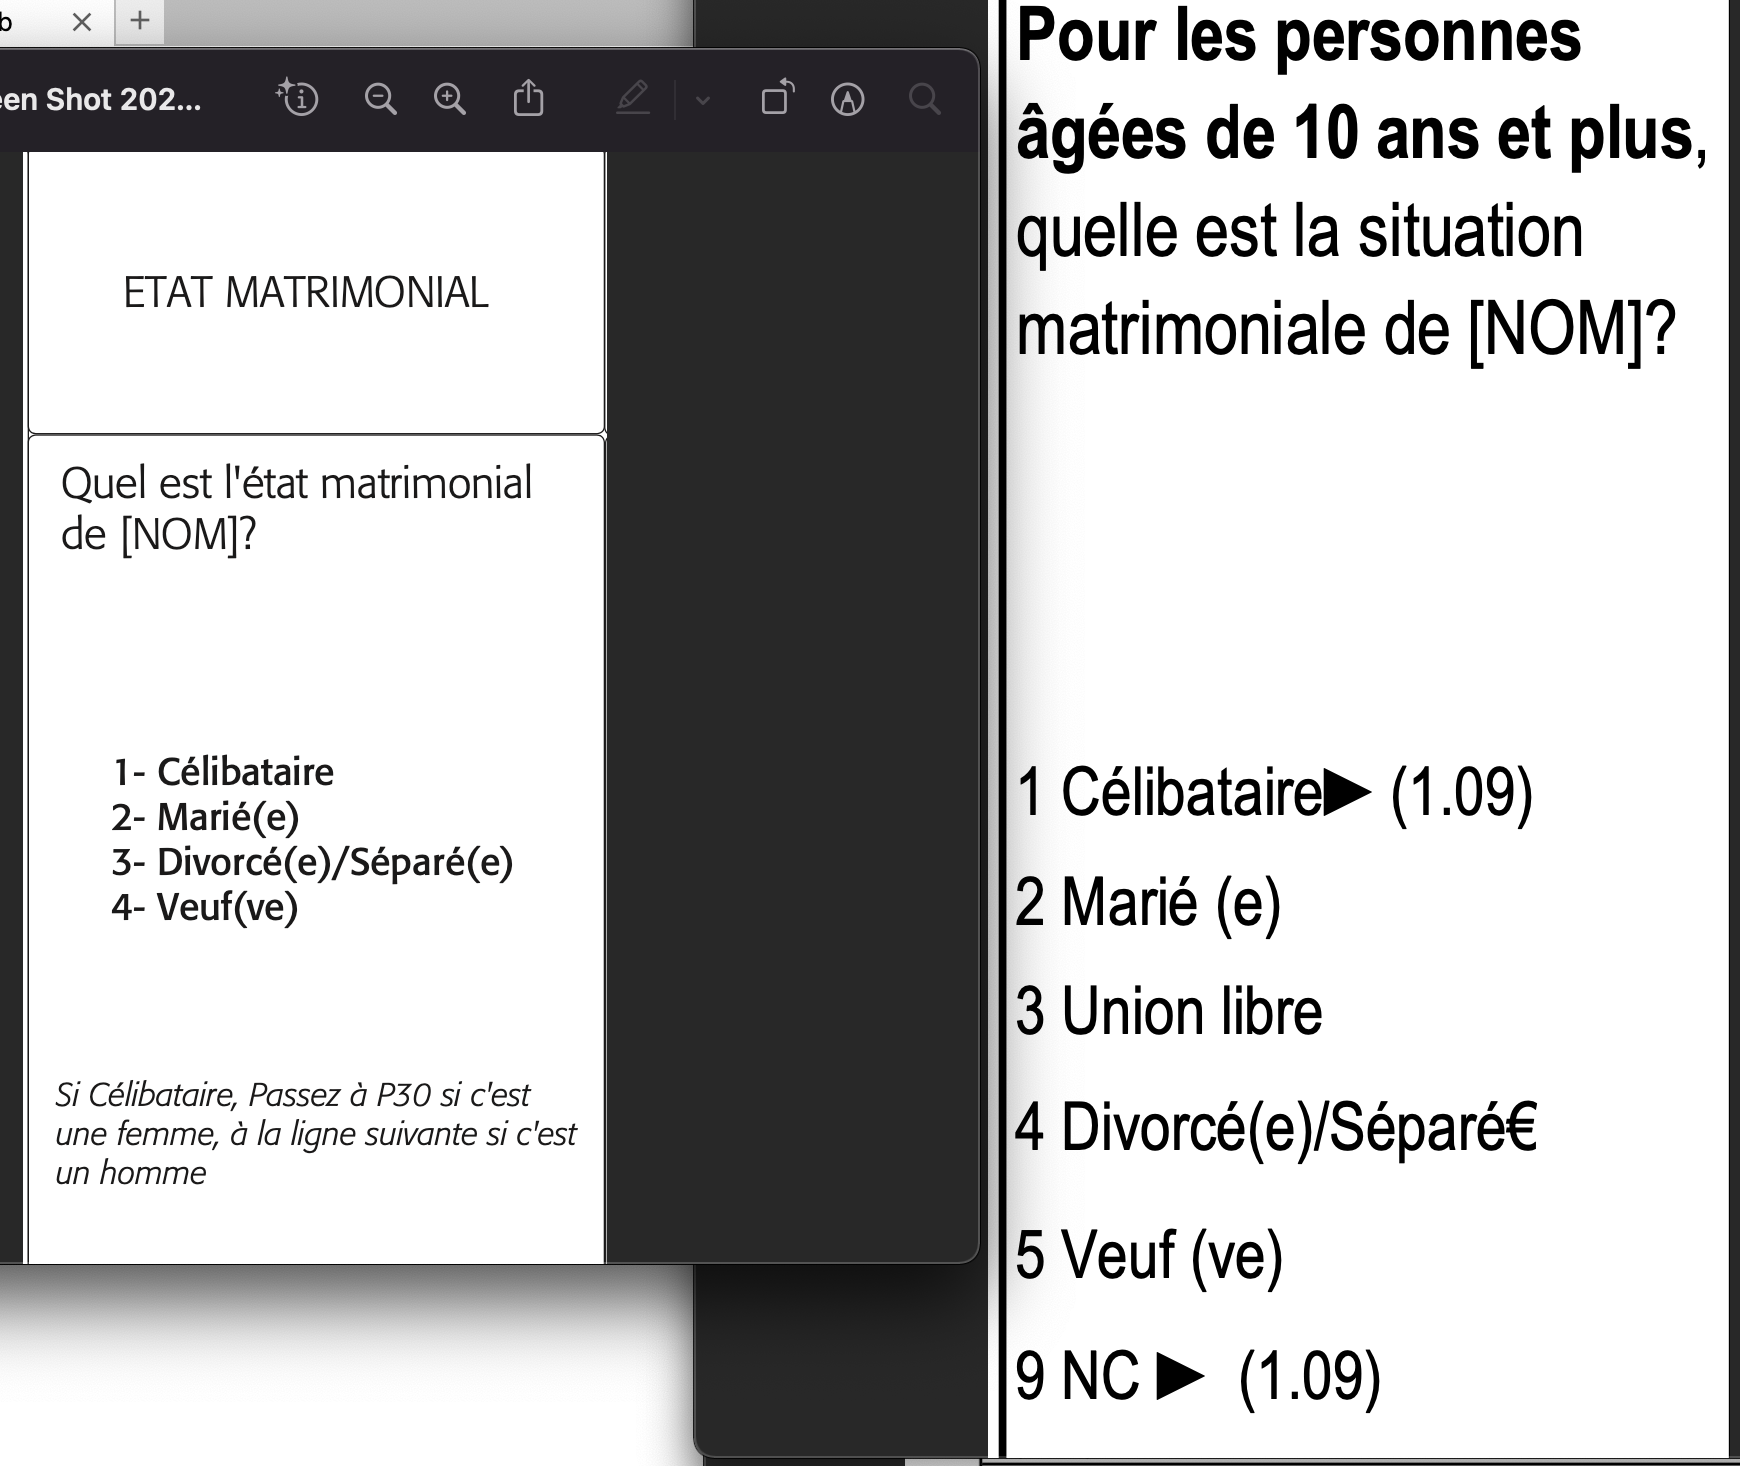

In [40]:
Image("../docs/images/marital_status.png", width=600)

In [41]:
def gen_var_marital_status(dfc_HoH, df_dhs):
    """
    Generate marital status variable for HH heads.
    1. For EPM, set 9 NC to single 
    2. For EPM, set 3 Union libre (cohabitation) to married
    """
    # ===============================================
    # KEEP ONLY HEAD OF HHS
    # ===============================================
    dfh_HoH = df_dhs.query('rel_HoH == 1')
    
    # ===============================================
    # RECATEGORIZE DHS MARITAL STATUS TO MATCH CENSUS 
    # ===============================================
    # Re-categorize DHS marital statuss
    marital_mappings = {0: 1, 1: 2, 2:2, 3:4, 4:3, 5:0}
    dfh_HoH['marital_status'] = dfh_HoH.marital_status.map(marital_mappings)
    dfc_HoH['marital_status'] = dfc_HoH.P28
    
    # Ensur there are no nulls
    assert dfc_HoH.marital_status.value_counts().sum() == len(dfc_HoH)
    assert dfh_HoH.marital_status.value_counts().sum() == len(dfh_HoH)
    
    dfc_out = dfc_HoH[[CENSUS_HHID,'marital_status']]
    dfh_out = dfh_HoH[[DHS_HHID,'marital_status']]
    
    # Print frequencies 
    print('Marital status, Census frequencies')
    print("#"*50)
    print(dfc_HoH.marital_status.value_counts(normalize=True, dropna=False))

    print()
    print('Marital status, DHS frequencies')
    print("#"*50)
    print(dfh_HoH.marital_status.value_counts(normalize=True, dropna=False))
    
    # add index
    dfc_out.set_index(CENSUS_HHID, inplace=True)
    dfh_out.set_index(DHS_HHID, inplace=True)
    
    
    return dfc_out, dfh_out

In [42]:
# generate marital status variable
dfc_mar, dfh_mar = gen_var_marital_status(dfc_HoH=DF_CENSUS_HOH, 
                                          df_dhs=DHS_HH_MM)
DHS_HH_VARS['marital_status'] = dfh_mar 
CENSUS_HH_VARS['marital_status'] = dfc_mar

Marital status, Census frequencies
##################################################
2   0.722
1   0.108
3   0.099
4   0.072
Name: marital_status, dtype: float64

Marital status, DHS frequencies
##################################################
2   0.705
3   0.142
4   0.103
1   0.050
Name: marital_status, dtype: float64


## Spouse in the household 
Cheeck whether there is a person considered a spouse in the house (wife/husband) 
to accound for single household.

In [43]:
def spouse_in_hh(vals):
    """
    Indicates whether there is a spouse in the HH
    """
    lst_vals = list(vals.values)
    if 2 in lst_vals:
        return 1
    else:
        return 0

In [44]:
def census_generate_spouse_in_hh():
    """
    Returns a HH level dataframe with column which shows
    wether HH has spouse (1) or not (0)
    """
    # Grab all rows where relationship is spouse
    # and then get their HH Id's
    has_spouse_hhs = SDF_CENSUS.filter('P03 == "1"').select(CENSUS_HHID).distinct().toPandas()
    
    # join those with the rest of HHs using DF_CENSUS_HOH
    # so that those HH which re only on left-side (DF_CENSUS_HOH)
    # have no spouse in them
    df = DF_CENSUS_HOH[[CENSUS_HHID]].merge(has_spouse_hhs, on=CENSUS_HHID, how='left', indicator=True)
    
    df['has_spouse'] = df._merge.map({'left_only': 0, 'both': 1})
    
    df.drop(columns=['_merge'], inplace=True)
    
    # add index
    df.set_index(CENSUS_HHID, inplace=True)
   
    return df

In [45]:
# generate whether tere is spouse or not in the household
dhs_spouse = DHS_HH_MM.groupby(DHS_HHID).agg(
                            has_spouse=('rel_HoH', spouse_in_hh))

dfc_spouse = census_generate_spouse_in_hh()


DHS_HH_VARS['has_spouse'] = dhs_spouse 
CENSUS_HH_VARS['has_spouse'] = dfc_spouse

In [46]:
# Print frequencies 
print('Whether there is a spouse in HH, Census frequencies')
print("#"*50)
print(dfc_spouse.has_spouse.value_counts(normalize=True, dropna=False))

print()
print('Whether there is a spouse in HH, DHS frequencies')
print("#"*50)
print(dhs_spouse.has_spouse.value_counts(normalize=True, dropna=False))

Whether there is a spouse in HH, Census frequencies
##################################################
1.000   0.690
0.000   0.310
Name: has_spouse, dtype: float64

Whether there is a spouse in HH, DHS frequencies
##################################################
1   0.684
0   0.316
Name: has_spouse, dtype: float64


## Add whether there is an adult woman in the household

In [47]:
def census_get_women_cnt_hh(adult_age=18):
    """
    Returns a HH level dataframe with column which shows
    number of women age 18 and older.
    """
    
    # Get all adult women
    pdf_women = SDF_CENSUS.filter((col("age") >= adult_age) &
                 (col("sex") == "2")).groupby(CENSUS_HHID).count().toPandas()
    pdf_women.rename (columns={'count':'adult_women_cnt'}, inplace=True)
    
    # join those with the rest of HHs using DF_CENSUS_HOH
    # so that those HHs with no adult women has NaN which we fill with 0
    df = DF_CENSUS_HOH[[CENSUS_HHID]].merge(pdf_women, on=CENSUS_HHID, how='left')
    df['adult_women_cnt'] = df['adult_women_cnt'].fillna(value=0)
    
    # add index
    df.set_index(CENSUS_HHID, inplace=True)
    
    return df

In [48]:
def dhs_get_women_cnt_hh(adult_age=18):
    """
    Returns a HH level dataframe with column which shows
    number of women age 18 and older.
    """
    
    # Get all adult women
    df_women = pd.DataFrame(DHS_HH_MM.query('age >= @adult_age & sex == 2').groupby([DHS_HHID]).size())
    df_women = df_women.rename(columns={0:'adult_women_cnt'}).reset_index()
    
    
    # join those with the rest of HHs using DF_CENSUS_HOH
    # so that those HHs with no adult women has NaN which we fill with 0
    dhs_all_hhs = DHS_HH_MM.drop_duplicates(subset=[DHS_HHID])[[DHS_HHID]]
    df = dhs_all_hhs.merge(df_women, on=DHS_HHID, how='left')
    df['adult_women_cnt'] = df['adult_women_cnt'].fillna(value=0)
    assert len(df) == DHS_NUM_HHS, 'Number of HHs in DHS need to be {}'.format(DHS_NUM_HHS)
    
    # add index
    df.set_index(DHS_HHID, inplace=True)     
    
    return df

In [49]:
dfc_women_cnt = census_get_women_cnt_hh()
dhs_women_cnt = dhs_get_women_cnt_hh()

DHS_HH_VARS['women_cnt'] = dhs_women_cnt 
CENSUS_HH_VARS['women_cnt'] = dfc_women_cnt

In [50]:
# Print frequencies 
print('Number of women in the HH, Census distribution')
print("#"*50)
print(dfc_women_cnt.adult_women_cnt.describe())

print()
print('Number of women in the HH, DHS distribution')
print("#"*50)
print(dhs_women_cnt.adult_women_cnt.describe())

Number of women in the HH, Census distribution
##################################################
count   6056809.000
mean          1.116
std           0.657
min           0.000
25%           1.000
50%           1.000
75%           1.000
max          14.000
Name: adult_women_cnt, dtype: float64

Number of women in the HH, DHS distribution
##################################################
count   20510.000
mean        1.149
std         0.649
min         0.000
25%         1.000
50%         1.000
75%         1.000
max         9.000
Name: adult_women_cnt, dtype: float64


## Extract Children variables

## Target variable (Stunting or not) and other basic variables

In [51]:
def prepare_DHS_stunting_variable(z_score_max_val=9990, z_score_var='hc70'):
    """
    Generate the target variable for prdiction as follows:
    1. height_age_zscore - numeric target variable representing number of standard deviationss from the mean
    2. Stunting - 1 if z-score < -2 and 0 otherwise
    3. Severe Stunting - 1 if z-score < -3 and 0 otherwise
    """
    # Use new WHO z-score as default
    if  z_score_var == 'hc70':
        z_score_col = 'height_age_std_WHO'
    else:
        z_score_col = 'height_age_std'
    
    # Lets keep the following columns
    child_vars = [PID, DHS_HHID, 'hh_weight', 'chd_age_months', 'sex', z_score_col]
    df = DHS_CHILD[child_vars]
    df.rename(columns={'sex': 'chd_sex', 'hh_weight': 'chd_samp_weight'}, inplace=True)
    
    # Drop large z-scores 
    df = df.query('{} < {}'.format(z_score_col, z_score_max_val))
    
    # Divide raw z-scoree by 100 as prescribed by DHS
    df['height_age_zscore'] = df[z_score_col]/100
    df.drop(columns=['height_age_std_WHO'], inplace=True)

    df['sev_stunted'] = df.height_age_zscore.apply(lambda x: 1 if x < -3 else 0)
    df['stunted'] = df.height_age_zscore.apply(lambda x: 1 if x < -2 else 0)
    
    # Check that the proportion of stunted children matches with DHS reported indicator
    df_stunt = pd.DataFrame(df.groupby('stunted')['chd_samp_weight'].sum()).reset_index()
    df_stunt['prop'] = df_stunt['chd_samp_weight']/df_stunt['chd_samp_weight'].sum()
    
    assert round(df_stunt.query('stunted == 1').iloc[0]['prop'], 1) == DHS_PROP_STUNTED
    df.set_index(PID, inplace=True)
    
    return df

In [52]:
# Prepare the targeet variable (stunting) in DHS
dhs_stunting = prepare_DHS_stunting_variable(z_score_max_val=9990, z_score_var='hc70')

# Prepare basic child variables in census
census_child_cols = [CENSUS_HHID, 'age_months', 'person_id', 'sex']
dfc_child = DF_CENSUS_CHILD[census_child_cols]
dfc_child.rename(columns={'sex':'chd_sex', 'age_months': 'chd_age_months'}, inplace=True)
dfc_child.set_index('person_id', inplace=True)

DHS_CHILD_VARS['stunting'] = dhs_stunting
CENSUS_CHILD_VARS['stunting'] = dfc_child

### Whether parents live in the same household

In [53]:
def gen_var_parents_in_hh(dhs_child, dfc_child):
    """
    Add variable to show whether parents stay in the same household as the child.
    """
    # Get for DHS
    dhs_child['mother_in_hh'] = dhs_child.mother_line_num.apply(lambda x: 0 if x == 0 else 1)
    dhs_child['father_in_hh'] = dhs_child.father_line_num.apply(lambda x: 0 if x == 0 else 1)
    
    dhs_child = dhs_child[[PID, DHS_HHID, 'mother_in_hh', 'father_in_hh']]
    dhs_child.set_index(PID, inplace=True)
    

    # Get for census 
    dfc_child['mother_in_hh'] = dfc_child.P16.apply(lambda x: 0 if x == 2 else 1)
    dfc_child['father_in_hh'] = dfc_child.P18.apply(lambda x: 0 if x == 2 else 1)
    
    dfc_child = dfc_child[[PID, CENSUS_HHID, 'mother_in_hh', 'father_in_hh']]
    dfc_child.set_index(PID, inplace=True)
    
    # Print frequencies 
    print('Mother lives in same HH, Census frequencies')
    print("#"*50)
    print(dfc_child.mother_in_hh.value_counts(normalize=True, dropna=False))

    print()
    print('Mother lives in same HH, DHS frequencies')
    print("#"*50)
    print(dhs_child.mother_in_hh.value_counts(normalize=True, dropna=False))
    
    # Print frequencies
    print()
    print('Father lives in same HH, Census frequencies')
    print("#"*50)
    print(dfc_child.father_in_hh.value_counts(normalize=True, dropna=False))

    print()
    print('Father lives in same HH, DHS frequencies')
    print("#"*50)
    print(dhs_child.father_in_hh.value_counts(normalize=True, dropna=False))
    
    return  dfc_child, dhs_child

In [54]:
dfc_parents, dhs_parents = gen_var_parents_in_hh(dhs_child=DHS_CHILD, dfc_child=DF_CENSUS_CHILD)

DHS_CHILD_VARS['parents_in_hh'] = dhs_parents 
CENSUS_CHILD_VARS['parents_in_hh'] = dfc_parents

Mother lives in same HH, Census frequencies
##################################################
1   0.933
0   0.067
Name: mother_in_hh, dtype: float64

Mother lives in same HH, DHS frequencies
##################################################
1   0.920
0   0.080
Name: mother_in_hh, dtype: float64

Father lives in same HH, Census frequencies
##################################################
1   0.826
0   0.174
Name: father_in_hh, dtype: float64

Father lives in same HH, DHS frequencies
##################################################
1   0.724
0   0.276
Name: father_in_hh, dtype: float64


## Education
### DHS education
> 1. **Education attainment.**  0 "No education"
     1 "Incomplete primary"
     2 "Complete primary"
     3 "Incomplete secondary"
     4 "Complete secondary"
     5 "Higher"
     8 "Don't know"
> 2. **Highest education level attained.**
0 "No education, preschool"
     1 "Primary"
     2 "Secondary"
     3 "Higher"
     8 "Don't know"

> 3. **Mothers highest education level.**
    0 "No education"
     1 "Primary"
     2 "Secondary"
     3 "Higher"
     8 "Don't know"

For education, we will use two variables which are available in both datasets as follows:
- Whether the person ever attended school
- Highest level of school of school completed.
We will use the variable in EPM (```What was the last class that [NAME] SUCCESSFULLY completed?```) as reference and convert the census question (```What is the highest level of education that <N0M) has attained during his studies?```) to match the EPM.

In [55]:
def add_var_census_attended_school(num):
    """
    Sets 1 if the person ever attended school and 0 if they did not. 
    Set 9 which seem to be missing to not attended (0)
    """
    if num == 1:
        return 1
    elif num == 2:
        return 1
    elif num == 0:
        return 0
    elif num == ' ':
        return NOT_APPLICABLE
    elif num == 9:
        return 0

In [56]:
def gen_var_ever_attennded_school(dfc_HoH, df_dhs):
    """
    Add whether HoH ever attendned school
    """
    # ===============================================
    # KEEP ONLY HEAD OF HHS
    # ===============================================
    dhs_HoH = df_dhs.query('rel_HoH == 1')
    
    # ===============================================
    # ADD VARIABLE 
    # ===============================================
    dfc_HoH['attended_sch'] = dfc_HoH.P21.apply(add_var_census_attended_school)
    dhs_HoH['attended_sch'] = dhs_HoH['ever_attended_sch']
    
    # Ensure there are no nulls
    assert dfc_HoH.attended_sch.value_counts().sum() == len(dfc_HoH)
    assert dhs_HoH.attended_sch.value_counts().sum() == len(dhs_HoH)
    
    dfc = dfc_HoH[[CENSUS_HHID, 'attended_sch']]
    dhs = dhs_HoH[[DHS_HHID,'attended_sch']]
    
    # Print frequencies 
    print('Ever attended school, Census frequencies')
    print("#"*50)
    print(dfc_HoH.attended_sch.value_counts(normalize=True, dropna=False))

    print()
    print('Ever attended school, DHS frequencies')
    print("#"*50)
    print(dhs_HoH.attended_sch.value_counts(normalize=True, dropna=False))
    
    # set index to HHID for easy merging at the end
    dhs.set_index(DHS_HHID, inplace=True)
    dfc.set_index(CENSUS_HHID, inplace=True)
    
    return dfc, dhs

### Ever attended school (formal or informal)
In EPM-21, the question is: ```has he been or is he currently studying in a formal or informal school?```. Thus, we convert, formal and informal to they have attended school before. In census, the question just asks whether the person ever attended school or is currently attending.

In [57]:
# generate ever attended school
dfc_sch, dhs_sch = gen_var_ever_attennded_school(dfc_HoH=DF_CENSUS_HOH, df_dhs=DHS_HH_MM)
DHS_HH_VARS['attended_school'] = dhs_sch 
CENSUS_HH_VARS['attended_school'] = dfc_sch

Ever attended school, Census frequencies
##################################################
1   0.760
0   0.240
Name: attended_sch, dtype: float64

Ever attended school, DHS frequencies
##################################################
1.000   0.790
0.000   0.210
Name: attended_sch, dtype: float64


### Highest education level completed/attended
In census, they use number of years completed at each level to indicate whether the person finished that level or not. 
In EPM, they ask the highest level successfully completed. However, the number of years in census when used to determine highest
level completed do not provide comparable distribution to EPM. On the other hand, when we ignore the years in census and just pick the highest
level attended, the distribution is similar to that of EPM. Consequently, the ```highest education``` variable represents the highest level 
attended regardless whether they successfully completed it or not. For those who never attended school, this level is ```0```.

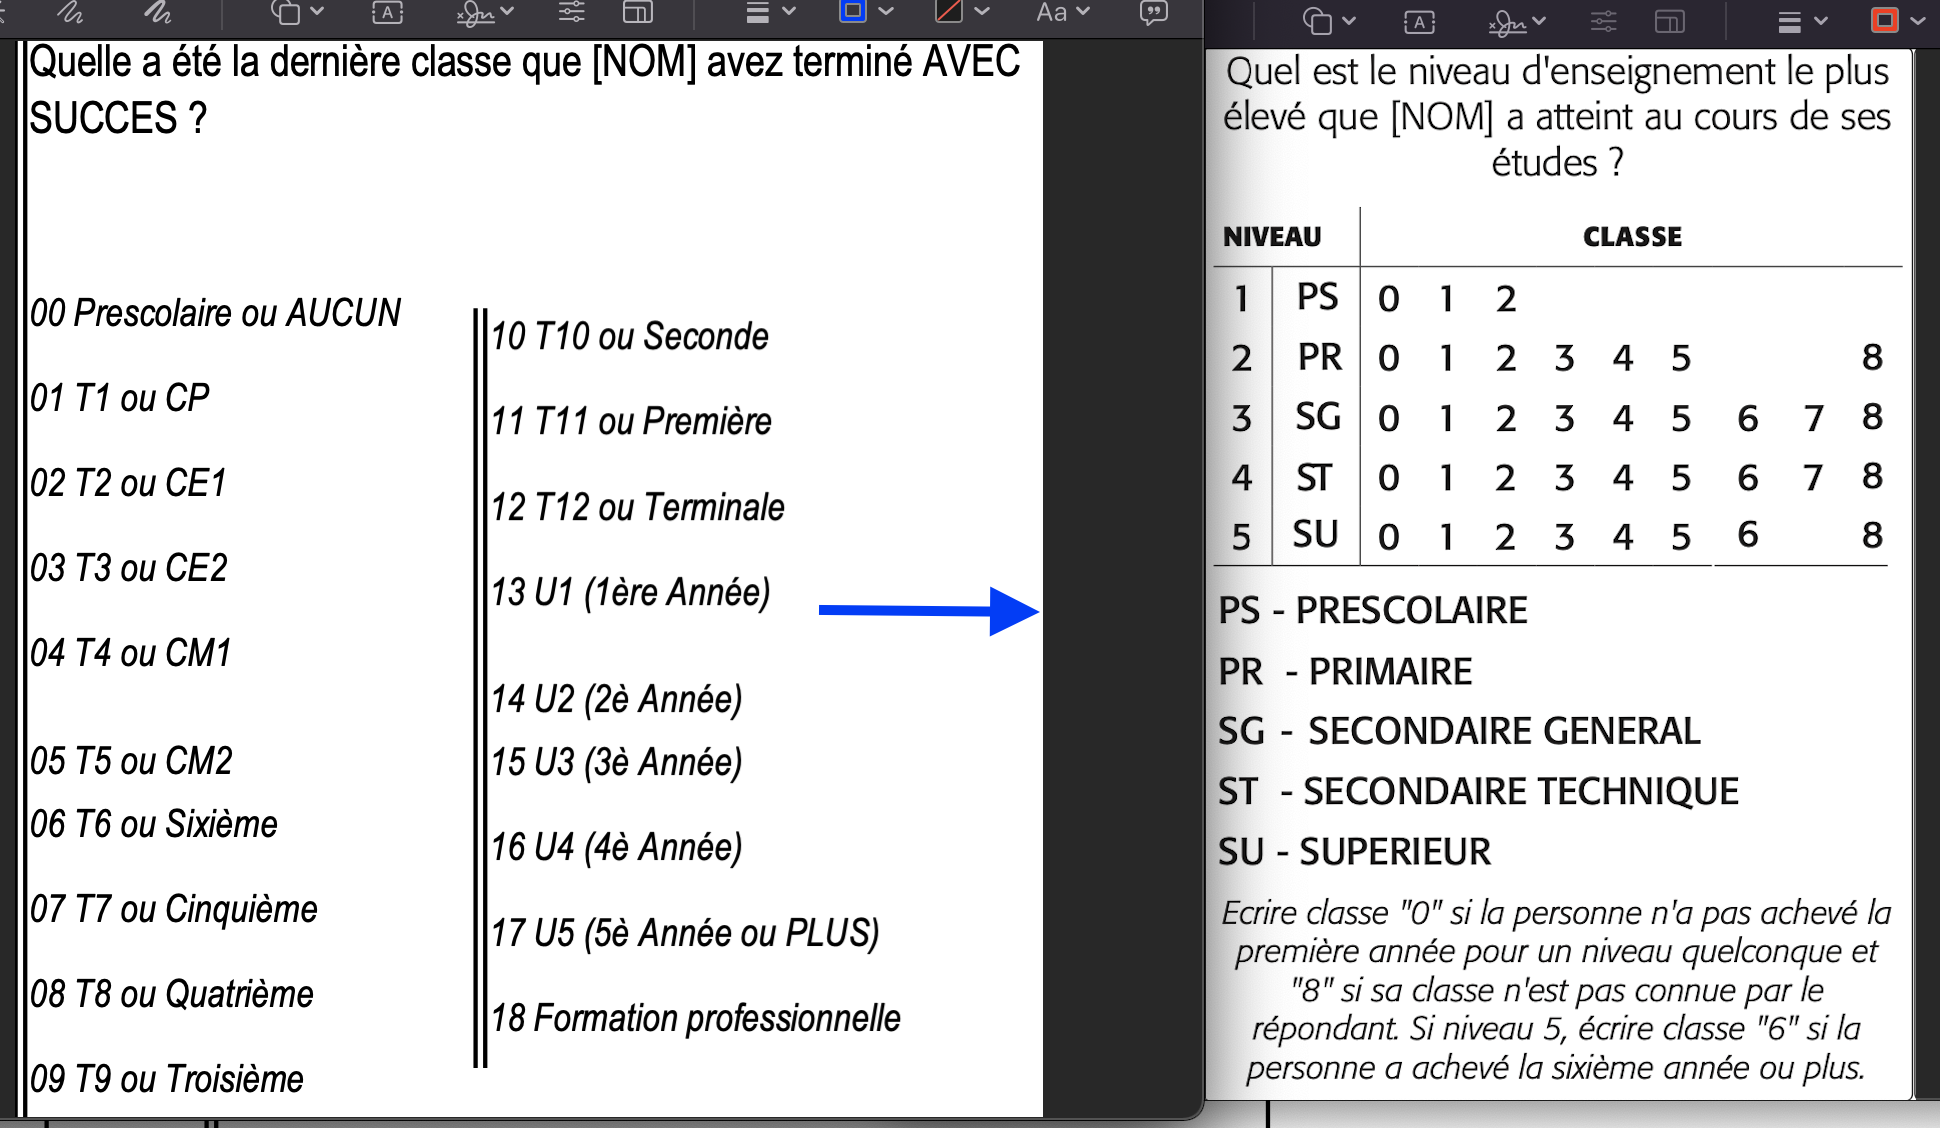

In [58]:
Image(filename='../docs/images/EPM-vs-census-educ.png', width=700) 

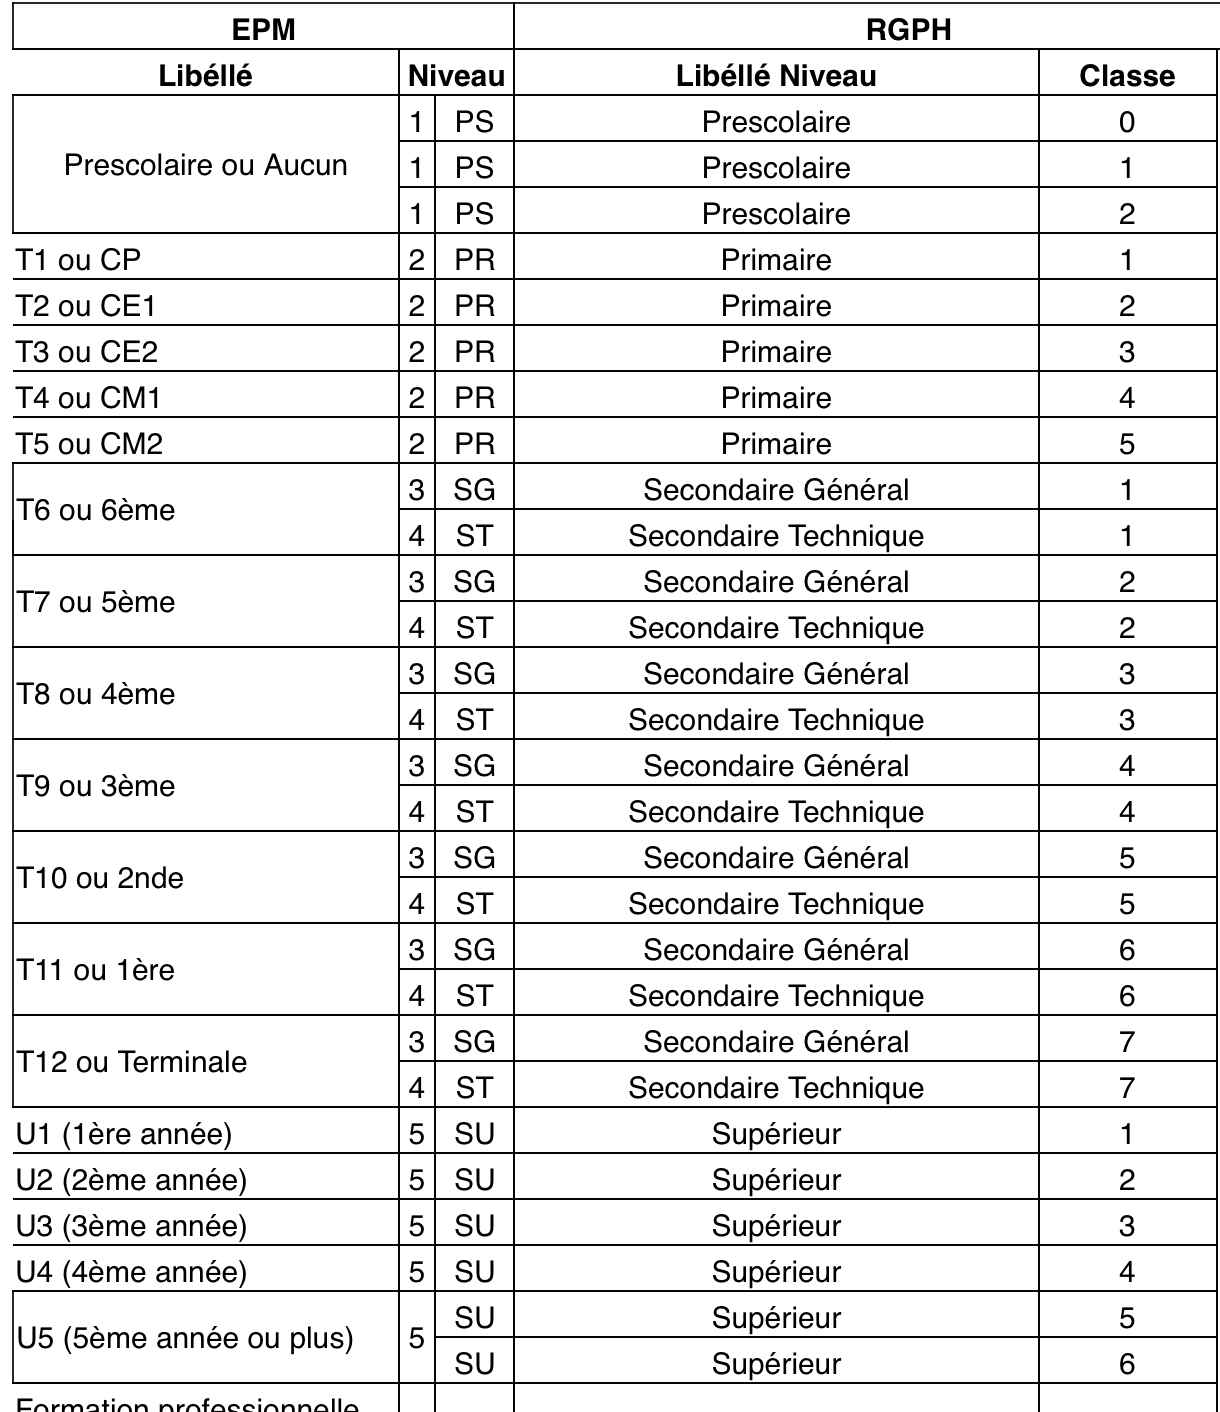

In [59]:
Image("../docs/images/educ_epm_vs_census.png", height=200, width=500)

In [60]:
def add_var_census_highest_educ_attended(row):
    """
    Get the highest level attended from question P2! and P22
    """
    # for convinience
    educ_level_dict = {0: 'None', 1: 'PS', 2:'PR', 3:'SG_ST', 4:'SG_ST', 5:'SU'}
    
    if row['P21'] == 0:
        return 0
    if np.isnan(row['P22N']):
        return 0
    else:
        educ_level = int(row['P22N'])
        return educ_level

In [61]:
def gen_var_highest_educ_level(dfc_HoH, df_dhs):
    """
    Add highest education attended
    TO DO: For census, there is a NONE category, 
    for people with no education with a value on education level
    """
    # ===============================================
    # KEEP ONLY HEAD OF HHS
    # ===============================================
    dhs_HoH = df_dhs.query('rel_HoH == 1')
    
    # ===============================================
    # ADD VARIABLE 
    # ===============================================
    educ_level_dict = {0:0, 1:0, 2:1, 3:2, 4:2, 5:3}
    dfc_HoH['highest_educ_lev'] = dfc_HoH.apply(lambda x: add_var_census_highest_educ_attended(x), axis=1)
    dfc_HoH['highest_educ_lev'] = dfc_HoH['highest_educ_lev'].map(educ_level_dict)
    dhs_HoH['highest_educ_lev'] = dhs_HoH['highest_educ_lev_attained'].replace(to_replace=8, value=0)
    
    # Ensure there are no nulls
    assert dfc_HoH.highest_educ_lev.value_counts().sum() == len(dfc_HoH)
    assert dhs_HoH.highest_educ_lev.value_counts().sum() == len(dhs_HoH)
    
    # setup output dataframes, just for readability
    dfc = dfc_HoH[[CENSUS_HHID,'highest_educ_lev']]
    dhs =  dhs_HoH[[DHS_HHID,'highest_educ_lev']]
    
    # Print frequencies 
    print('Highest education level, Census frequencies')
    print("#"*50)
    print(dfc_HoH.highest_educ_lev.value_counts(normalize=True, dropna=False))

    print()
    print('Highest education level, DHS frequencies')
    print("#"*50)
    print(dhs_HoH.highest_educ_lev.value_counts(normalize=True, dropna=False))
    
    # set index to HHID for easy merging at the end
    dhs.set_index(DHS_HHID, inplace=True)
    dfc.set_index(CENSUS_HHID, inplace=True)
    
    return dfc, dhs

In [62]:
# generate highest level attended variable
dfc_highest_educ, dhs_highest_educ = gen_var_highest_educ_level(dfc_HoH=DF_CENSUS_HOH, df_dhs=DHS_HH_MM)
DHS_HH_VARS['highest_educ'] = dhs_highest_educ  
CENSUS_HH_VARS['highest_educ'] = dfc_highest_educ

Highest education level, Census frequencies
##################################################
1   0.417
2   0.289
0   0.248
3   0.046
Name: highest_educ_lev, dtype: float64

Highest education level, DHS frequencies
##################################################
1   0.448
2   0.274
0   0.232
3   0.045
Name: highest_educ_lev, dtype: float64


## Dwelling unit characteristics

### Material for the wall
The categories for census and the survey are exactly the same as shown below.

**census wall categories** 

    O. Cinder block, stone
    1. Baked brick
    2. Clay/Unbaked Brick
    3. Stem/bark/leaves
    4. Sheet metal (corrugated or galvanized)
    5. Plank
    6. Bozaka
    7. Material of recovery
    8.Other  (Specify)

**DHS wall categories:**
    
    
    11.NO WALL 
    12.BAMBOO/CANE/PALM/TRUNK
    13. EARTH
    21. BAMBOO WITH MUD 
    22. STONES WITH MUD 
    23. COVERED ADOBE 
    24. PLYWOOD 
    25. CARDBOARD 
    26. RECOVERED WOOD
    31. CEMENT
    32. STONE WITH LIME/CEMENT
    33. BRICKS
    34.CEMENT BLOCKS 35.COVERED ADOBER
    36.WOODENBOARD/SHINGLES
    37. SHEET
    96. OTHER(SPECIFY)

To synchronize DHS and census, use the following categories based on DHS broad categories:
1. Natural 
2. Rudimentary 
3. Developed 
4. Other

We use dictionary below to convert census categories to DHS major categories:
> census_wall_to_dhs_major_categories = {0: 3, 1: 3, 2:1, 3:1, 4: 3, 5: 3, 6:2, 7:4, 8:4}

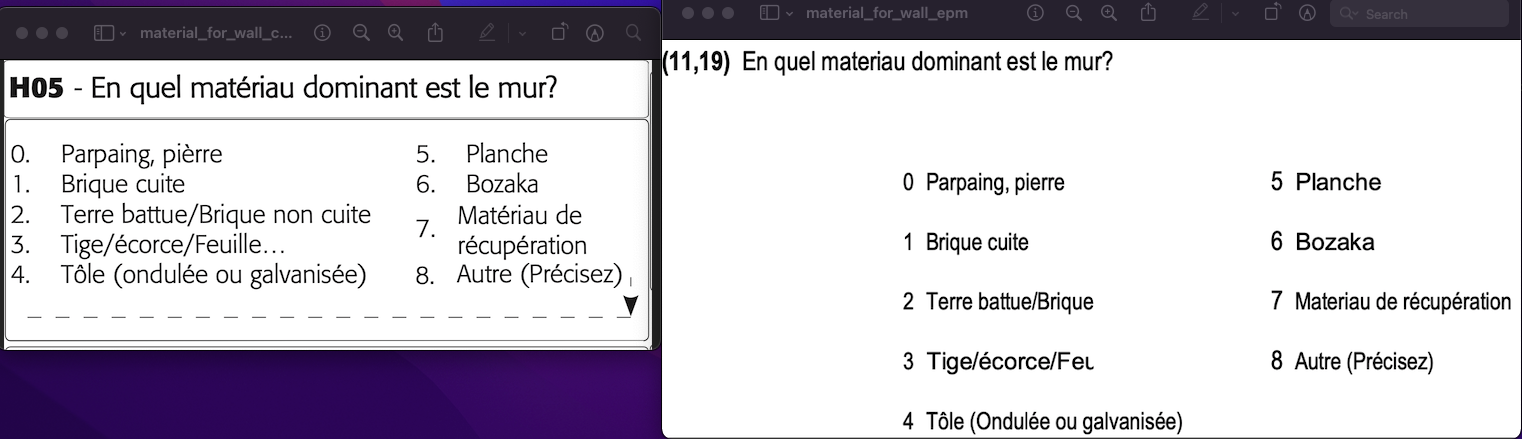

In [63]:
Image("../docs/images/wall-materials.png")

In [64]:
def add_var_dhs_wall_roof_floor_broad_categories(val):
    """
    Recategorize DHS wall, roof and floor into three main categories of natural, rudimentary and developed/finished
    """
    
    if val < 15:
        return 1
    elif 15 < val < 30:
        return 2
    elif 30 < val < 40:
        return 3
    else:
        return 4

### Material for the roof

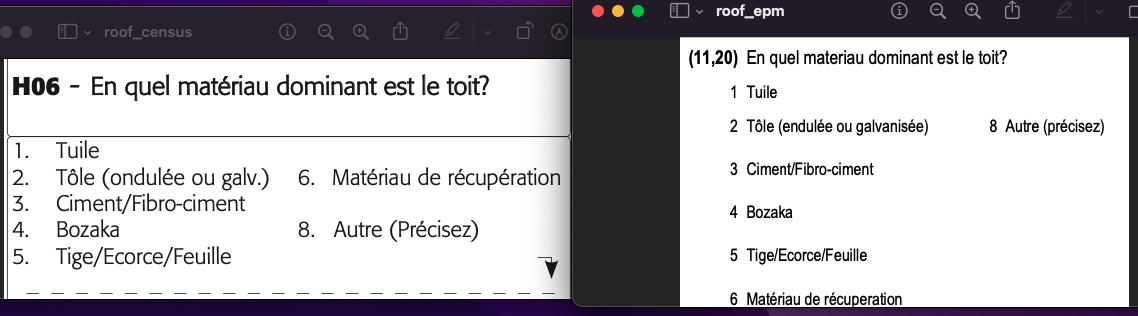

In [65]:
Image("../docs/images/roof.png")

**DHS roof**

    10 "NATURAL"
    11 "No roof"
    12 "Thatch/palm leaf"
    13 "Clods of earth"
    20 "RUDIMENTARY"
    21 "Mat"
    22 "Palm/bamboo"
    23 "Wood planks"
    24 "Cardboard"
    30 "FINISHED"
    31 "Metal"
    32 "Wood"
    33 "Zinc/Cement fiber"
    34 "Tiles/slate"
    35 "Cement"
    36 "Shingles"
    96 "Other"

**Census roof:**
> 
1. Tile
2. Sheet metal (corrugated or galv.)
3. Cement/fiber cement
4. Bozaka
5. Stem/Bark/Leaf
6. Salvaged material
8. Other (Specify)

Census to DHS major categories conversion below:
> roof_census_to_dhs_major_categories = {1: 3, 2:3, 3:3, 4: 1, 5:2, 6:4, 7:4}

### Material for the floor

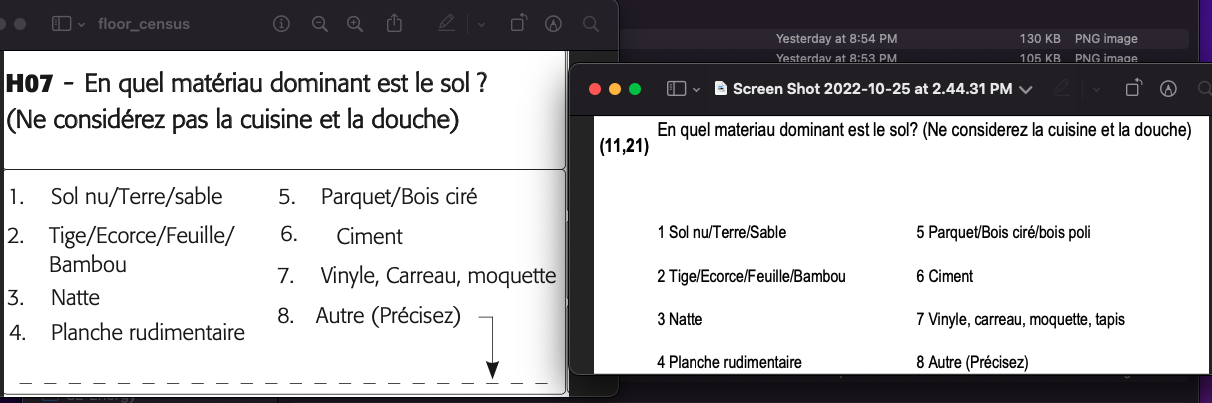

In [66]:
Image("../docs/images/floor.png")

**DHS floor material**

    10 "NATURAL"
    11 "Earth/sand"
    12 "Dung"
    20 "RUDIMENTARY"
    21 "Wood planks"
    22 "Palm/bamboo"
    23 "Mats"
    30 "FINISHED"
    31 "Parquet or polished wood"
    32 "Vinyl or asphalt strips"
    33 "Ceramic tiles"
    34 "Cement"
    35 "Carpet"
    96 "Other"

**Census floor material**

    1.Bare Soil/Dirt/Sand
    2. Stem/Bark/Leaf/Bamboo
    3. Mat
    4. Rudimentary plank
    5. Parquet/waxed wood
    6.Cement
    7. Vinyl, Tile, Carpet
    8. Other (Specify)

We convert both DHS and census categories into 4 major categories based on DHS major categories as follows:
1. Natural 
2. Rudimentary 
3. Finished
4. Other

For DHS, we simply follow the provided mappings while for census, we use the following dictionary to re-categorize:

> floor_census_to_dhs_major_categories = {1: 1, 2: 2, 3: 2, 4: 3, 5: 3, 6: 3, 7: 3, 8:4}

### Energy for cooking
In the EPM survey, they ask for top-2 sources of energy for cooking and this is stored in two seperate variables:
```q11_53a``` and ```q11_53b```. I choose to use only the first variable representing the main source of energy for cooking.

**Census energy for cooking**
   
        1.Charcoal
        2.Firewood
        3.Oil
        4.Gas
        5.electricity
        6.Dung
        8.Other, give details)

**DHS energy for cooking**

         1 "Electricity"
         2 "LPG"
         3 "Natural gas"
         4 "Biogas"
         5 "Kerosene"
         6 "Coal, lignite"
         7 "Charcoal"
         8 "Wood"
         9 "Straw/shrubs/grass"
        10 "Agricultural crop"
        11 "Animal dung"
        95 "No food cooked in house"
        96 "Other"

We use the census categories.Thus, we map the many DHS categories to census categories using the dictionary below:
> cooking_dhs_to_census = {1: 5, 2: 4, 3: 4, 4:4, 5: 3, 6: 8, 7: 1, 8: 2, 9:2, 10:8, 11:6, 95:8, 96:8}

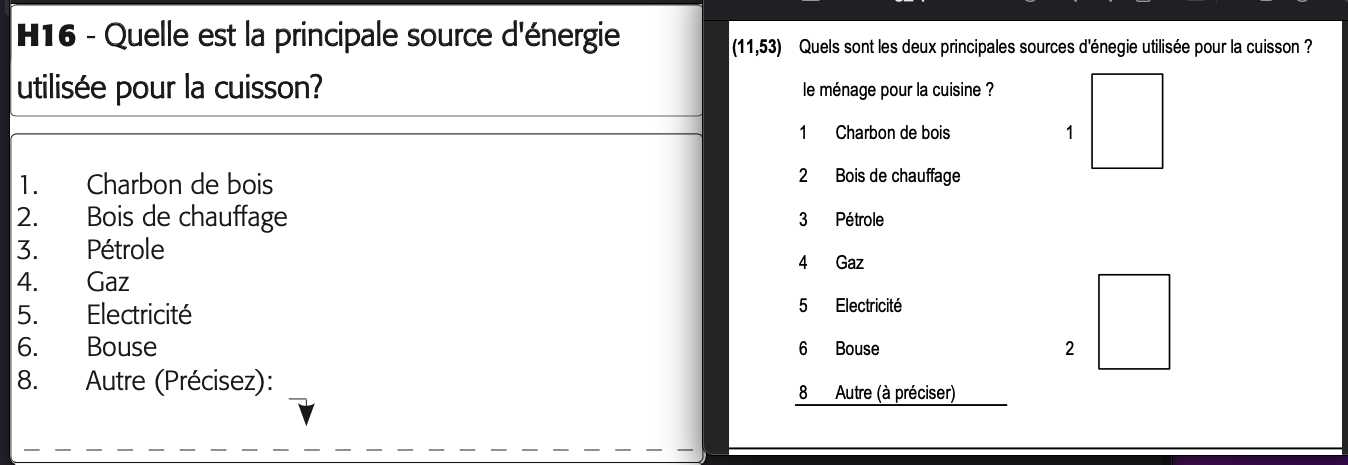

In [67]:
Image("../docs/images/cooking.png")

In both the census and survey, categories ```1``` and ```2``` make up over 90% of the observations.

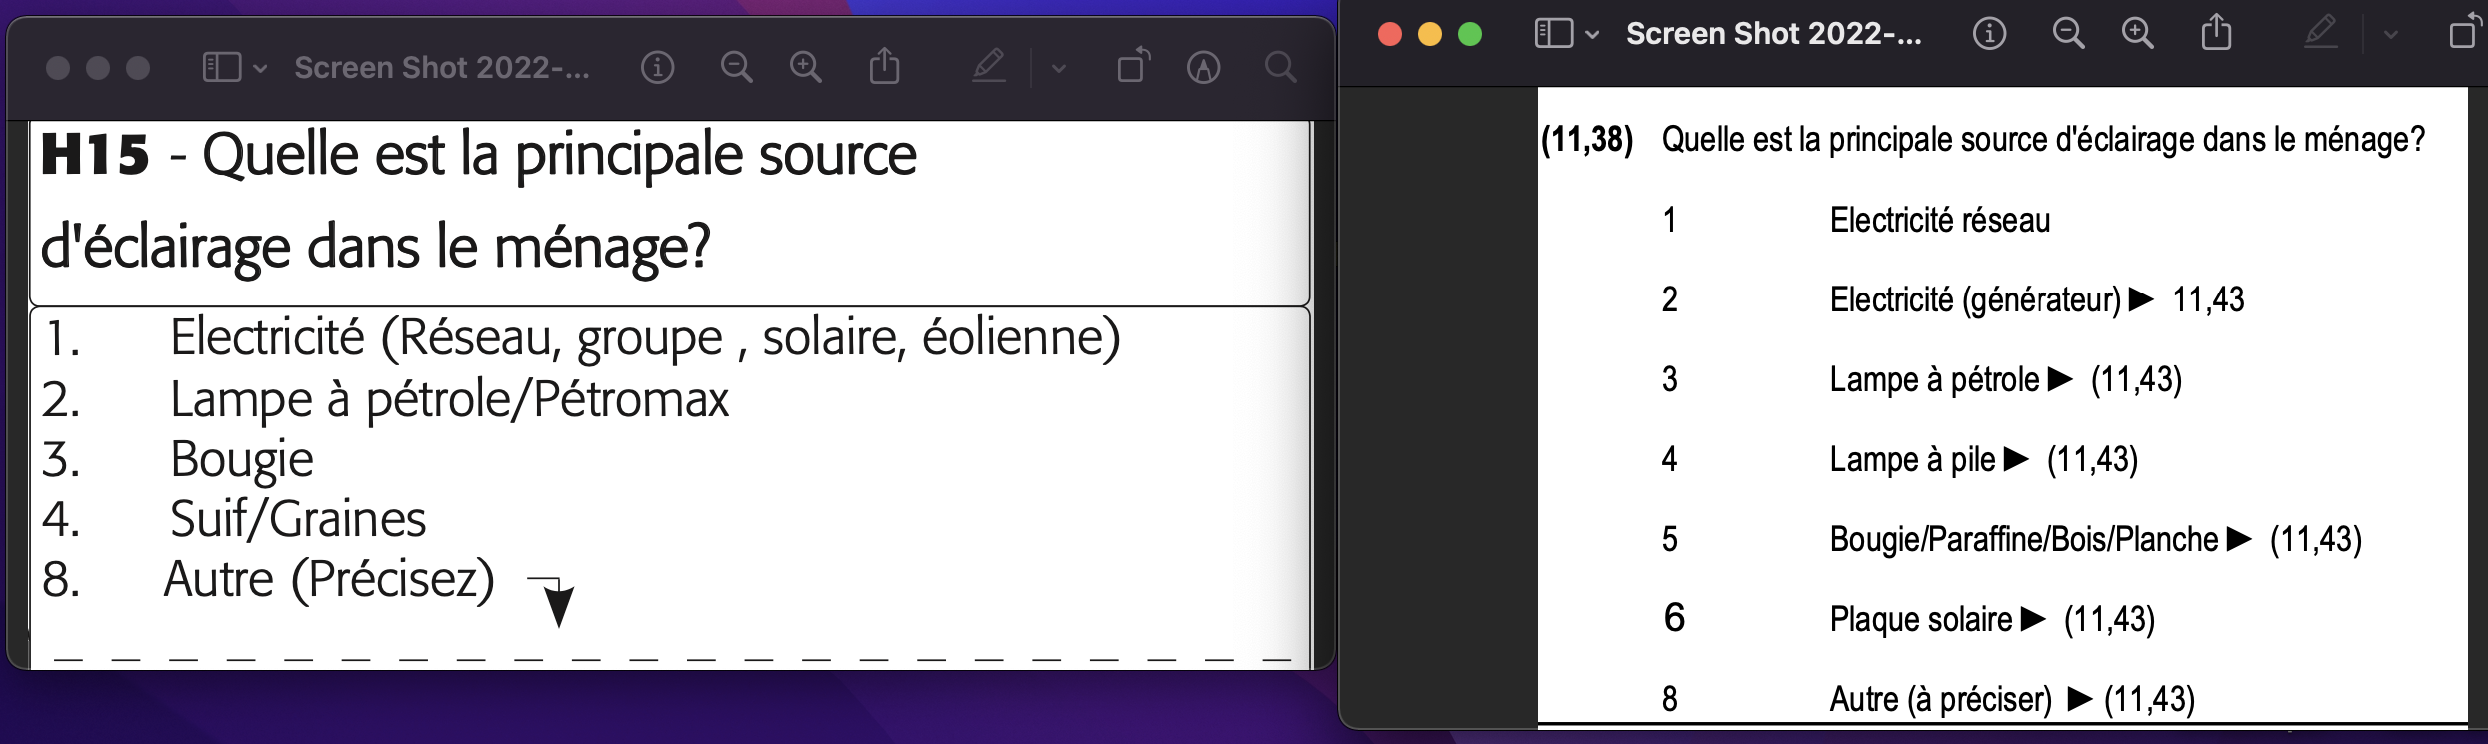

In [68]:
Image("../docs/images/lighting.png")

In [69]:
def gen_var_dwelling_units_attributes(dfc_HoH, df_dhs):
    """
    Add the following dwelling units characteristics
    1. HH type
    2. rent. If HH doesnt pay rent (because they own the house and other reasons), we set it to 0
    3. Material for the wall, roof and floor
    4. Energy for cooking and lighting
    For, all variables, as theey are categorical, if a value is missing, we replace with the mode 
    as we cannot have NaN/missing values for thee sake of model building
    """
    # ===============================================
    # KEEP ONLY HEAD OF HHS
    # ===============================================
    dhs_HoH = df_dhs.query('rel_HoH == 1')
    
    # since we create many columns, lets store them here
    cols_to_output = []
    
    
    # ===============================================
    # MATERIAL FOR WALL
    # ===============================================
    # For consistency, lets start all categories at 1 instead of 0
    census_wall_to_dhs_major_categories = {0: 3, 1: 3, 2:1, 3:1, 4: 3, 5: 3, 6:2, 7:4, 8:4}
    dfc_HoH['wall'] = dfc_HoH['H05$1'].map(census_wall_to_dhs_major_categories)
    dhs_HoH['wall'] = dhs_HoH['wall'].apply(lambda x: add_var_dhs_wall_roof_floor_broad_categories(x))
    
    # Ensure there are no null values
    assert dhs_HoH['wall'].value_counts().sum() == len(dhs_HoH)
    assert dfc_HoH['wall'].value_counts().sum() == len(dfc_HoH)
    
    # Print frequencies 
    print('Wall, Census frequencies')
    print("#"*50)
    print(dfc_HoH.wall.value_counts(normalize=True, dropna=False))

    print()
    print('Wall, DHS frequencies')
    print("#"*50)
    print(dhs_HoH.wall.value_counts(normalize=True, dropna=False))
    
    # add to list of variables
    cols_to_output.append('wall')
    
    # ===============================================
    # MATERIAL FOR ROOF
    # ===============================================
    roof_census_to_dhs_major_categories = {1: 3, 2:3, 3:3, 4: 1, 5:2, 6:1, 7:4}
    dfc_HoH['roof'] = dfc_HoH['H06$1'].map(roof_census_to_dhs_major_categories)
    dhs_HoH['roof'] = dhs_HoH['roof'].apply(lambda x: add_var_dhs_wall_roof_floor_broad_categories(x))
    
    # Ensure there are no null values
    assert dhs_HoH['roof'].value_counts().sum() == len(dhs_HoH)
    assert dfc_HoH['roof'].value_counts().sum() == len(dfc_HoH)
    
    # Print frequencies 
    print()
    print('Roof, Census frequencies')
    print("#"*50)
    print(dfc_HoH.roof.value_counts(normalize=True, dropna=False))

    print()
    print('Roof, DHS frequencies')
    print("#"*50)
    print(dhs_HoH.roof.value_counts(normalize=True, dropna=False))

    # add to list of variables
    cols_to_output.append('roof')
    
    # ===============================================
    # MATERIAL FOR FLOOR
    # ===============================================
    floor_census_to_dhs_major_categories = {1: 1, 2: 2, 3: 2, 4: 3, 5: 3, 6: 3, 7: 3, 8:4}
    dfc_HoH['floor'] = dfc_HoH['H07$1'].map(floor_census_to_dhs_major_categories)
    dhs_HoH['floor'] = dhs_HoH['floor'].apply(lambda x: add_var_dhs_wall_roof_floor_broad_categories(x))
    
    # Ensure there are no null values
    assert dhs_HoH['floor'].value_counts().sum() == len(dhs_HoH)
    assert dfc_HoH['floor'].value_counts().sum() == len(dfc_HoH)
    
    # Print frequencies 
    print()
    print('Floor, Census frequencies')
    print("#"*50)
    print(dfc_HoH.floor.value_counts(normalize=True, dropna=False))

    print()
    print('Floor, DHS frequencies')
    print("#"*50)
    print(dhs_HoH.floor.value_counts(normalize=True, dropna=False))
    
    # add to list of variables
    cols_to_output.append('floor')

    # ===============================================
    # ENERGY FOR COOKING
    # ===============================================
    # add the cooking variable for EPM
    cooking_dhs_to_census = {1: 5, 2: 4, 3: 4, 4:4, 5: 3, 6: 1, 7: 1, 8: 2, 9:2, 10:8, 11:8, 95:8, 96:8}
    dhs_HoH['cooking'] = dhs_HoH['cooking_fuel'].map(cooking_dhs_to_census)
    dfc_HoH['cooking'] = dfc_HoH['H16$1'].replace(6,8)
    
    # Ensure there are no null values
    assert dhs_HoH['cooking'].value_counts().sum() == len(dhs_HoH)
    assert dfc_HoH['cooking'].value_counts().sum() == len(dfc_HoH)
    
    # Print frequencies 
    print()
    print('Cooking, Census frequencies')
    print("#"*50)
    print(dfc_HoH.cooking.value_counts(normalize=True, dropna=False))
    
    print()
    print('Cooking, DHS frequencies')
    print("#"*50)
    print(dhs_HoH.cooking.value_counts(normalize=True, dropna=False))
    
    # add to list of variables
    cols_to_output.append('cooking')
    
    
    # setup output dataframes, just for readability
    dfc = dfc_HoH[[CENSUS_HHID] + cols_to_output]
    dhs =  dhs_HoH[[DHS_HHID] + cols_to_output]
    
    # set index to HHID for easy merging at the end
    dhs.set_index(DHS_HHID, inplace=True)
    dfc.set_index(CENSUS_HHID, inplace=True)
    
    return dfc, dhs

In [70]:
# add dwelling units characteristics
dfc_du, dhs_du = gen_var_dwelling_units_attributes(dfc_HoH=DF_CENSUS_HOH, df_dhs=DHS_HH_MM)
DHS_HH_VARS['dwelling_attr'] = dhs_du
CENSUS_HH_VARS['dwelling_attr'] = dfc_du

Wall, Census frequencies
##################################################
1   0.597
3   0.379
2   0.023
4   0.001
Name: wall, dtype: float64

Wall, DHS frequencies
##################################################
1   0.498
3   0.383
2   0.116
4   0.003
Name: wall, dtype: float64

Roof, Census frequencies
##################################################
3   0.441
1   0.381
2   0.178
Name: roof, dtype: float64

Roof, DHS frequencies
##################################################
1   0.486
3   0.454
2   0.059
4   0.001
Name: roof, dtype: float64

Floor, Census frequencies
##################################################
3   0.458
2   0.439
1   0.103
Name: floor, dtype: float64

Floor, DHS frequencies
##################################################
2   0.513
3   0.384
1   0.092
4   0.010
Name: floor, dtype: float64

Cooking, Census frequencies
##################################################
2   0.701
1   0.285
3   0.004
4   0.004
5   0.004
8   0.000
Name: cooking, dtype: 

## Household assets
We add the following assets:
1. Radio (```a``` in census and ```128``` in EPM)
2. TV (```b``` in census and ```131``` in EPM)
3. Video player (```c``` in census and ```133``` in census)
4. Stove(gas or electric)(```d``` in census and ```149``` in census)
5. Refrigerator (```e``` in census and ```120``` or ```121``` in census because they ask for freezeer separately)
6. Washing machine (```f``` in census and ```122``` in EPM)
7. Sewing machine (```g``` in census and ```119``` in EPM)
8. Computer (```h``` in census and ```141``` in EPM)
9. Internet equipment (```i``` in census and ```146``` in EPM)
10. Car (```j``` in census and ```103``` in EPM)
11. Air Conditioner/Fan (```k``` in census and ```138``` or ```139``` in EPM)
12. Motorcycle/Scooter/Bajaj/Quad (```l``` in census and ```104``` in EPM)
13. Fixed telephone (```m``` in census and ```144``` in EPM)
14. Mobile phone (```n``` in census and ```145``` in EPM)
15. Bicycle/rickshaw ((```O``` in census and ```105``` in EPM)

In [71]:
# create helper variables from above information
# assets variable names
ASSET_VAR_NAMES = ['radio','TV','video_player','refrigerator',
                   'sewing_machine','computer', 'car','AC_fan','motorcycle_scooter',
                   'telephone','mobilephone','bicycle']

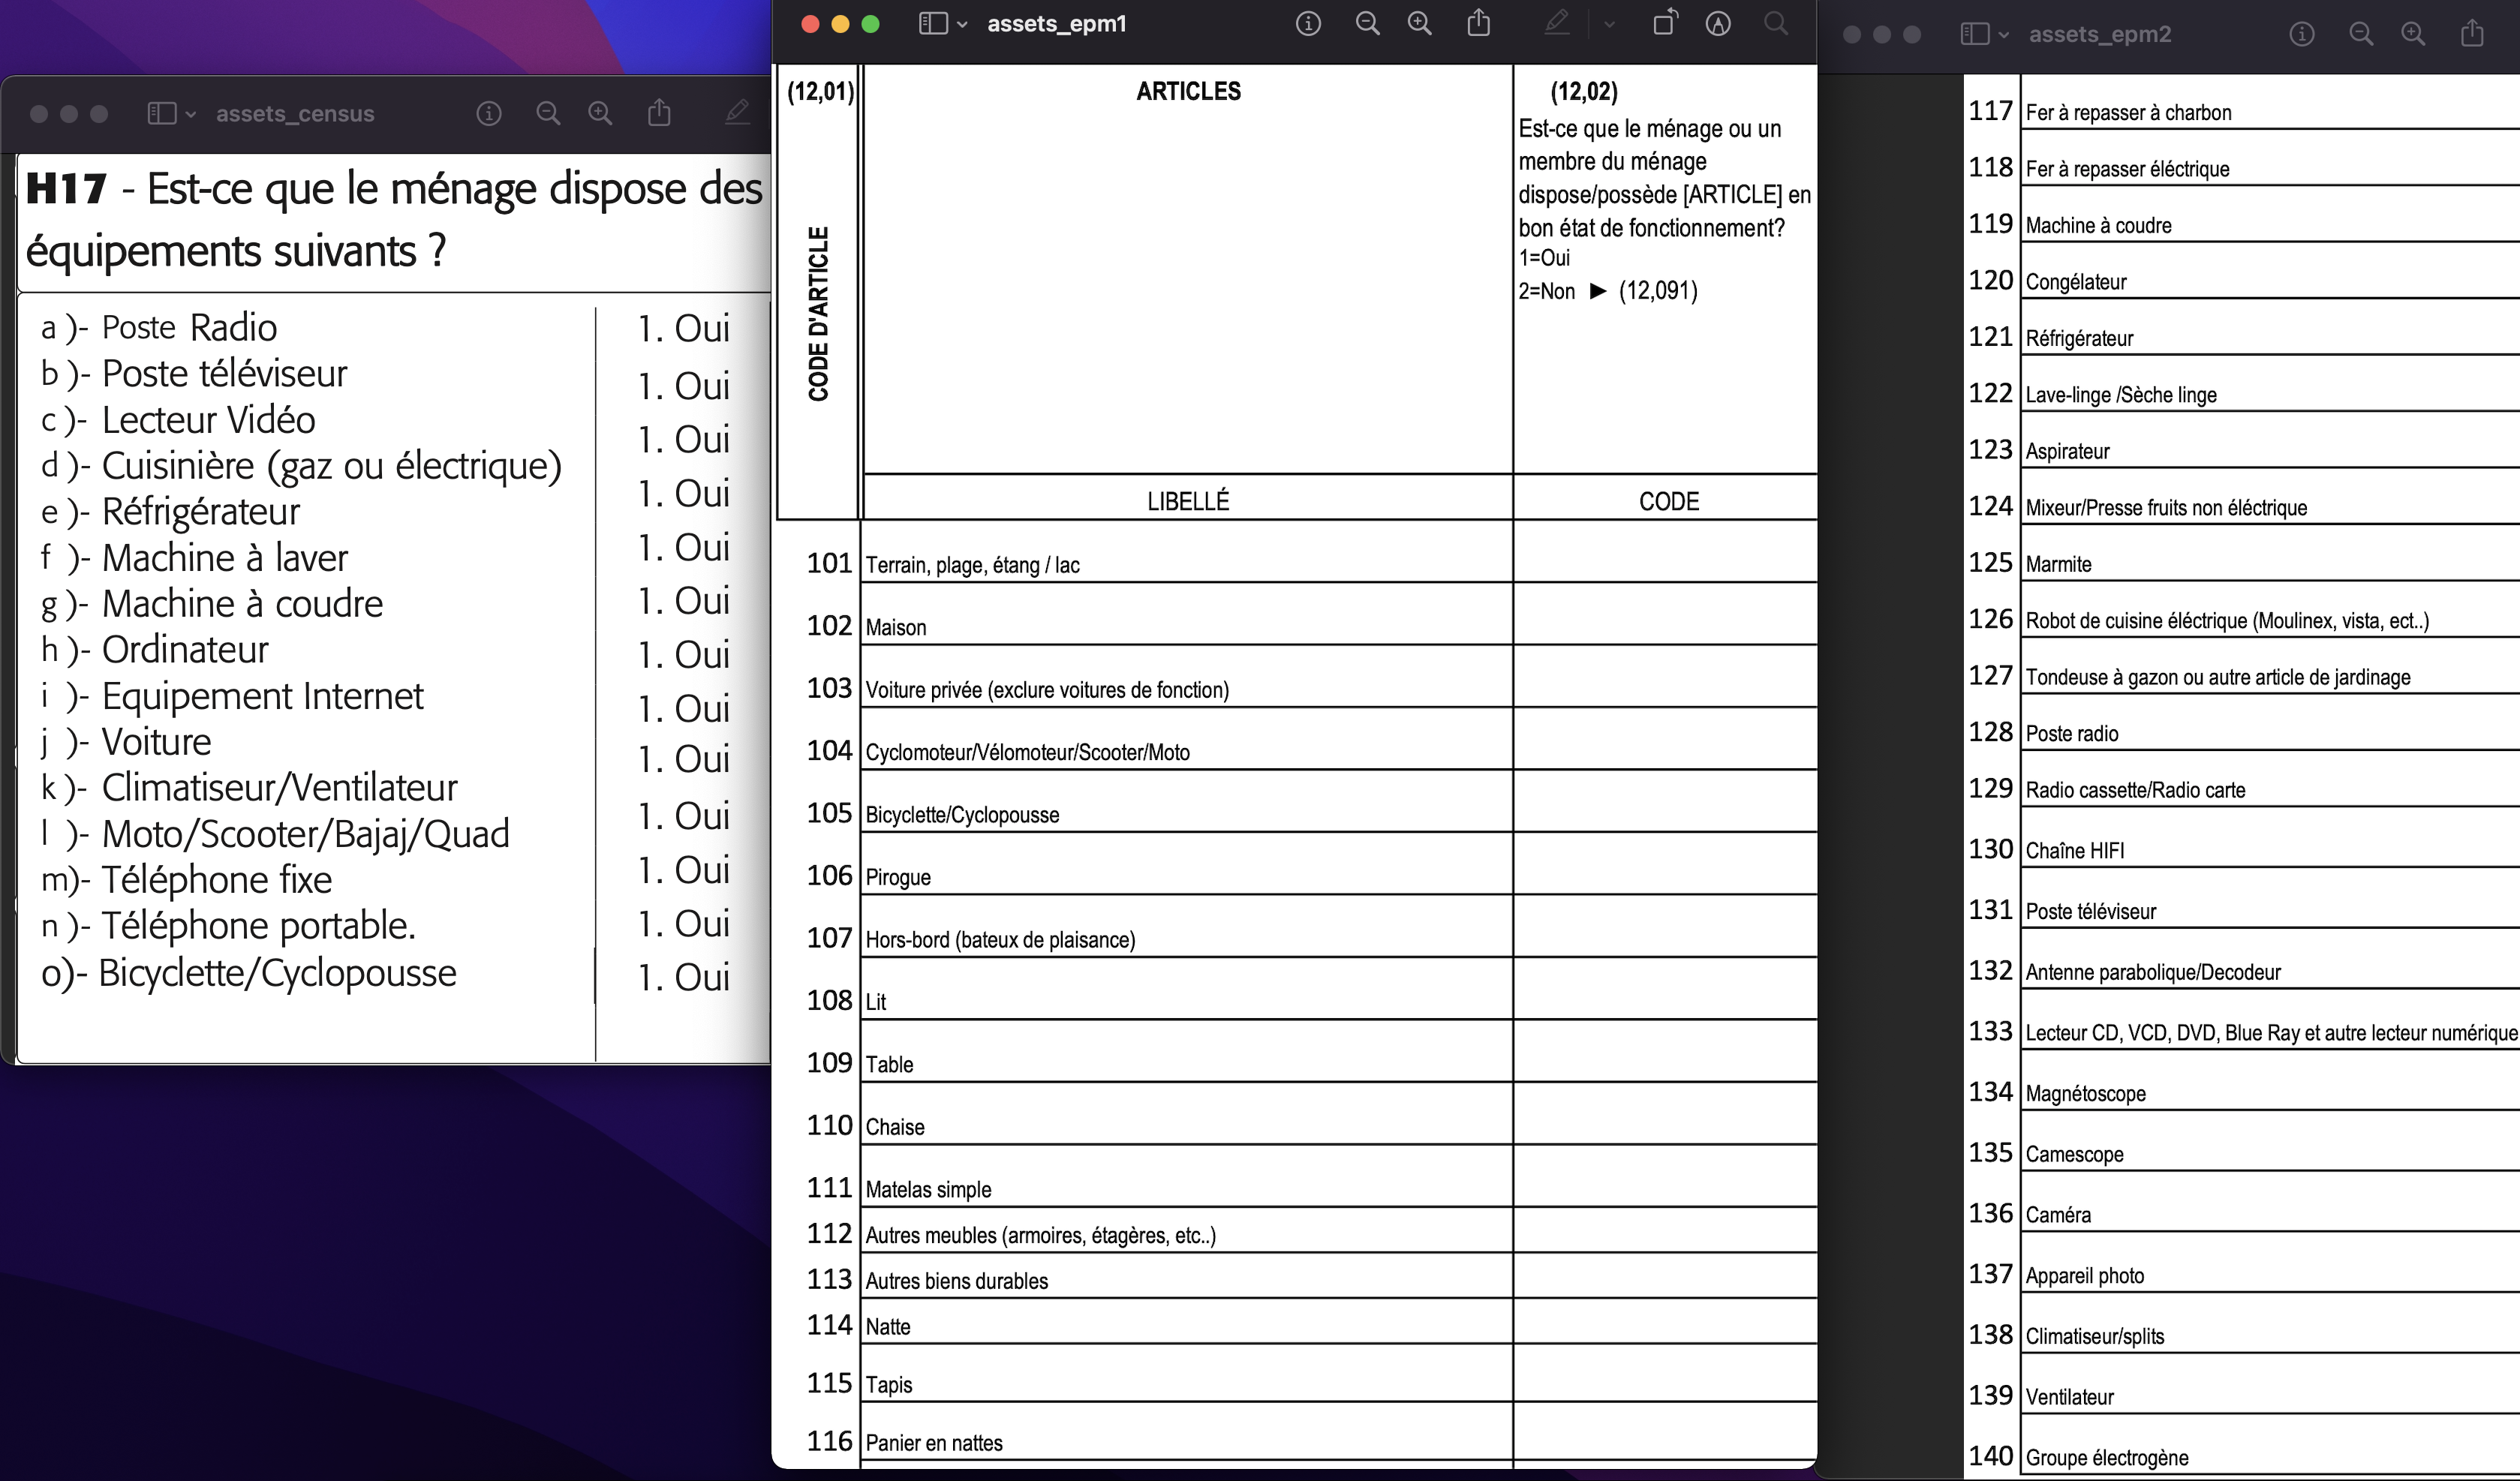

In [72]:
Image("../docs/images/assets.png")

In [73]:
def extract_census_asset_vars(df_census, asset_cols):
    """
    Extract asset variables for census as described above.
    """
    # ===============================================
    # KEEP ONLY HEAD OF HHS
    # ===============================================
    df_census_hh = df_census.query('{} == 0'.format(CENSUS_HOH))
    
    # kepe only reequired columns
    census_assets = {'H17A$1':'radio', 'H17B$1':'TV', 'H17C$1':'video_player', 
                     'H17D$1':'stove', 'H17E$1':'refrigerator', 
                     'H17F$1':'washing_machine', 'H17G$1': 'sewing_machine' , 
                     'H17H$1':'computer', 
                     'H17J$1':'car', 'H17K$1':'AC_fan', 'H17L$1':'motorcycle_scooter', 
                     'H17M$1':'telephone', 'H17N$1':'mobilephone', 
                     'H17O$1':'bicycle'}
    df_census_hh.rename(columns=census_assets, inplace=True)
    keep_cols = ['PROVINCE', 'REGION', 'DISTRICT', 'COMMUNES', 'urban_rural', 'IDMEN'] + asset_cols
    df_census_hh = df_census_hh[keep_cols]
    
    # replace 2 for no with 0
    df_census_hh = df_census_hh.replace(2, 0)
    
    # set NaN to 0
    if ASSETS_SET_NAN_TO_ZERO:
        df_census_hh.fillna(0, inplace=True)
    
    df_census_hh[asset_cols] = df_census_hh[asset_cols].astype(int)
    
    df_out = df_census_hh[[CENSUS_HHID] + asset_cols]
    
    # set index to HHID for easy merging at the end
    df_out.set_index(CENSUS_HHID, inplace=True)
    
    return df_out

In [75]:
# generate asset variables for census 
dfc_assets = extract_census_asset_vars(df_census=DF_CENSUS_HOH, asset_cols=ASSET_VAR_NAMES)

dhs_assets = DHS_HH_MM[[DHS_HHID] + ASSET_VAR_NAMES]
dhs_assets.drop_duplicates(subset=[DHS_HHID], inplace=True)
dhs_assets.set_index(DHS_HHID, inplace=True)

DHS_HH_VARS['assets'] = dhs_assets
CENSUS_HH_VARS['assets'] = dfc_assets

In [76]:
for asset in ASSET_VAR_NAMES:
    print()
    print('{}, Census frequencies'.format(asset))
    print("#"*50)
    print(dfc_assets[asset].value_counts(normalize=True, dropna=False))
    
    print()
    print('{}, DHS frequencies'.format(asset))
    print("#"*50)
    print(dhs_assets[asset].value_counts(normalize=True, dropna=False))


radio, Census frequencies
##################################################
1   0.608
0   0.392
Name: radio, dtype: float64

radio, DHS frequencies
##################################################
0   0.578
1   0.422
Name: radio, dtype: float64

TV, Census frequencies
##################################################
0   0.784
1   0.216
Name: TV, dtype: float64

TV, DHS frequencies
##################################################
0   0.786
1   0.214
Name: TV, dtype: float64

video_player, Census frequencies
##################################################
0   0.799
1   0.201
Name: video_player, dtype: float64

video_player, DHS frequencies
##################################################
0   0.853
1   0.147
Name: video_player, dtype: float64

refrigerator, Census frequencies
##################################################
0   0.961
1   0.039
Name: refrigerator, dtype: float64

refrigerator, DHS frequencies
##################################################
0   0.947
1   0

# Consolidate variables
---

## Merge all dataframes
Now merge all census variables into a single dataframe and do the same for EPM and save as a CSV file. For now, we are skipping the following variables:
1. **Occupation codes.** There seem to be zero matces between codes in census and those in survey agre aggregation

In [95]:
def consolidate_census_vars():
    """
    Helper function to consolidate all variables for census data.
    """
    # =====================================
    # COMBINE HH LEVEL VARS
    # ====================================
    # HH level dataframe for those HHs with children
    df_chd_hh = DF_CENSUS_HOH_CHILD[[CENSUS_HHID, 'province', 'prov_code', 'region',
       'reg_code', 'district', 'dist_code', 'sex', 'age', 'urban_rural']]
    df_chd_hh.set_index(CENSUS_HHID, inplace=True)
    num_hhs_child = len(df_chd_hh)  # Number of census HHs wih children
    df_chd_hh_tmp = df_chd_hh.copy(deep = True)
    
    
    # We dont need the sex_age dataframe
    CENSUS_HH_VARS.pop('sex_age', None)
    for k, v in CENSUS_HH_VARS.items():
        try:
            assert v.index.name == CENSUS_HHID, 'Index should be IDMEN'
            df_chd_hh_tmp = df_chd_hh_tmp.merge(v, left_index=True, right_index=True, how='inner')
            assert len(df_chd_hh_tmp) ==  num_hhs_child
        except Exception as e:
            print(e)
            print('CHECK', k)
    
    assert len(df_chd_hh_tmp) == num_hhs_child, 'Number of HHs do not match'
    
    # ====================================
    # COMBINE PERSON  LEVEL VARS
    # ====================================
    # HH level dataframe for those HHs with children
    df_chd = DF_CENSUS_CHILD[[PID, CENSUS_HHID, 'sex', 'age_months']]
    df_chd.rename(columns={'sex': 'chd_sex', 'age_months': 'chd_age_months'}, inplace=True)	
    df_chd.set_index(PID, inplace=True)
    
    df_parents = CENSUS_CHILD_VARS['parents_in_hh'][['mother_in_hh', 'father_in_hh']]
    df_chd2 = df_chd.merge(df_parents, left_index=True, right_index=True, how='inner')
    
    assert len(df_chd2) == len(DF_CENSUS_CHILD)
    
    # ========================================
    # APPEND HH VARS TO INDIVIDUAL LEVEL VARS
    # =======================================
    df_chd2[PID] = df_chd2.index
    df_chd2.reset_index(drop=True, inplace=True)
    df_chd3 = df_chd2.merge(df_chd_hh_tmp, on=CENSUS_HHID, how='inner')
    # Rename census HH-ID column to be same as that of DHS
    df_chd3.rename(columns={CENSUS_HHID:DHS_HHID}, inplace=True)
    assert len(df_chd3) == len(DF_CENSUS_CHILD)
    
    # add source column since thwy wil be in same file
    df_chd3['source'] = 'census'
    
    # Ensure all column names are in loweer case
    df_chd3 = df_chd3.rename(columns=str.lower)
    
    return df_chd3

In [94]:
def consolidate_dhs_vars():
    """
    Helper function to consolidate all variables for DHS data.
    """
    # =====================================
    # COMBINE HH LEVEL VARS
    # ====================================
    # HHs with children
    dhs_hh_with_child = DHS_CHILD[[DHS_HHID]].drop_duplicates(subset=[DHS_HHID])
    
    # Get only HH heads from all persons data and keep 
    # only few columns
    dhs_HoH = DHS_HH_MM.query('rel_HoH == 1')
    dhs_HoH = dhs_HoH[[DHS_HHID, 'province', 'prov_code', 'region',
       'reg_code', 'district', 'dist_code', 'cluster', 'sex', 'age', 'urban_rural', 'hh_weight']]
    
    # Keep only those HHs with children
    dhs_HoH_child = dhs_HoH.merge(dhs_hh_with_child, on=DHS_HHID, how='inner')
    dhs_HoH_child.set_index(DHS_HHID, inplace=True)
    num_hhs_child = len(dhs_HoH_child)  # Number of DHS HHs wih children
    
    # Use to merge al dataframes into one
    dhs_HoH_child_tmp = dhs_HoH_child.copy(deep = True)
    
    # We dont need the sex_age dataframe
    DHS_HH_VARS.pop('sex_age', None)
    for k, v in DHS_HH_VARS.items():
        try:
            assert v.index.name == DHS_HHID, 'Index should be DHS HH-ID'
            dhs_HoH_child_tmp = dhs_HoH_child_tmp.merge(v, left_index=True, right_index=True, how='inner')
            assert len(dhs_HoH_child_tmp) ==  num_hhs_child, 'Number of HHs do not match'
        except Exception as e:
            print(e)
            print('CHECK', k)
    
    assert len(dhs_HoH_child_tmp) == num_hhs_child, 'Number of HHs do not match'
    
    
    # ====================================
    # COMBINE PERSON  LEVEL VARS
    # ====================================
    # HH level dataframe for those HHs with children
    df_chd = DHS_CHILD_VARS['stunting'][['hh_id', 'chd_age_months', 'chd_sex','height_age_zscore', 'stunted']]
    df_parents = DHS_CHILD_VARS['parents_in_hh'][['mother_in_hh', 'father_in_hh']]
    df_chd2 = df_chd.merge(df_parents, left_index=True, right_index=True, how='inner')
    
    assert len(df_chd2) == len(df_chd), 'Number of children do not match'
    
    # ========================================
    # APPEND HH VARS TO INDIVIDUAL LEVEL VARS
    # =======================================
    df_chd2[PID] = df_chd2.index
    df_chd2.reset_index(drop=True, inplace=True)
    df_chd3 = df_chd2.merge(dhs_HoH_child_tmp, on=DHS_HHID, how='inner')
    assert len(df_chd3) == len(df_chd), 'Number of children do not match'
    
    # Add source column 
    df_chd3['source'] = 'dhs'
    
    # Ensure all column names are in loweer case
    df_chd3 = df_chd3.rename(columns=str.lower)
    
    return df_chd3

In [183]:
def merge_census_and_dhs(dhs, dfc):
    """
    Stack the two datasets together.
    """ 
    # =================================================
    # MAKE SURE WE HAVE SAME COLUMNS
    # =================================================
    # Make sure the dataframes has the same columns except for the
    # ones we expect to be different
    vars_not_in_census = [HH_WEIGHT, 'cluster', 'stunted', 'height_age_zscore']

    assert set(dhs.columns.difference(dfc.columns)) == set(vars_not_in_census), 'Columns different'

    assert len(dfc.columns.difference(dhs.columns)) == 0, 'Census DF has some columns not in DHS'

    # =================================================
    # CHECK CATEGORICAL FEATURES
    # =================================================
    # Make sure data type for categorical features is int
    categorical_features = ['chd_sex',
           'mother_in_hh', 'father_in_hh','sex', 
           'urban_rural', 'hh_size',
           'marital_status', 'has_spouse', 'attended_sch',
           'highest_educ_lev', 'wall', 'roof', 'floor', 'cooking', 'radio', 'tv',
           'video_player', 'refrigerator', 'sewing_machine', 'computer', 'car',
           'ac_fan', 'motorcycle_scooter', 'telephone', 'mobilephone', 'bicycle']
    dhs[categorical_features] = dhs[categorical_features].astype(int)
    
    dfc[categorical_features] = dfc[categorical_features].astype(int)

    # Make sure categories are the same for the two datasets
    for c in categorical_features:
        if c in vars_not_in_census or c =='hh_size':
            continue
        try:
            assert sorted(list(dhs[c].value_counts().index)) == sorted(list(dfc[c].value_counts().index))
        except:
            print('Check categories for {}, they dont match'.format(c))
       
    # =================================================
    # MERGE THEE DATASETS NOW
    # =================================================
    df = pd.concat([dhs, dfc], axis=0)
    col_arrangment = ['region', 'reg_code', 'province', 'prov_code',
       'district', 'dist_code', 'urban_rural', 'person_id', 'hh_weight', 'source', 'sex', 'age',
       'chd_age_months', 'chd_sex',
       'mother_in_hh', 'father_in_hh', 'hh_size', 'persons_below15',
       'persons_above64', 'persons_between15to64', 'dep_ratio',
       'marital_status', 'has_spouse', 'adult_women_cnt', 'attended_sch',
       'highest_educ_lev', 'wall', 'roof', 'floor', 'cooking', 'radio', 'tv',
       'video_player', 'refrigerator', 'sewing_machine', 'computer', 'car',
       'ac_fan', 'motorcycle_scooter', 'telephone', 'mobilephone', 'bicycle','height_age_zscore', 'stunted']
    
    df = df[col_arrangment]
    
    # ====================================
    # WRITE TO FILE
    # ====================================
    # Write base file
    out_csv = DIR_OUTPUT.joinpath('stunting-dataset.csv')
    df.to_csv(out_csv, index=False)
    
    # Save one-hot encoded file
    all_features = ['urban_rural', 'sex', 'age',
       'chd_age_months', 'chd_sex', 'mother_in_hh', 'father_in_hh', 'hh_size',
       'persons_below15', 'persons_above64', 'persons_between15to64',
       'dep_ratio', 'marital_status', 'has_spouse', 'adult_women_cnt',
       'attended_sch', 'highest_educ_lev', 'wall', 'roof', 'floor', 'cooking',
       'radio', 'tv', 'video_player', 'refrigerator', 'sewing_machine',
       'computer', 'car', 'ac_fan', 'motorcycle_scooter', 'telephone',
       'mobilephone', 'bicycle']
    
    cat_features = ['urban_rural', 'sex', 'chd_sex', 'mother_in_hh', 'father_in_hh',
                    'marital_status', 'has_spouse', 'attended_sch', 'highest_educ_lev', 
                    'wall', 'roof', 'floor', 'cooking',
                   'radio', 'tv', 'video_player', 'refrigerator', 'sewing_machine',
                   'computer', 'car', 'ac_fan', 'motorcycle_scooter', 'telephone',
                   'mobilephone', 'bicycle'] + GEOGRAPHIC_REGION_VARS
    cont_features = list(set(all_features) - set(cat_features))
    
    df_onehot = pd.get_dummies(df, columns=cat_features, 
                                drop_first=ONE_HOT_ENCODING_DROP_FIRST)

    out_csv_onehot = DIR_OUTPUT.joinpath('stunting-dataset-featurized.csv')
    df_onehot.to_csv(out_csv_onehot, index=False)

In [96]:
# Consoidate dataframes and save output data files
dfc = consolidate_census_vars()
dhs = consolidate_dhs_vars()

In [184]:
merge_census_and_dhs(dhs, dfc)

Check categories for roof, they dont match
Check categories for floor, they dont match
23/03/21 08:59:52 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 35890259 ms exceeds timeout 120000 ms
23/03/21 08:59:52 WARN SparkContext: Killing executors is not supported by current scheduler.


# Summary of generated variables
----
The summary below provides an overview of the variables generated and can be used as a data dictionary to understand what each column contains. For details, refer to preceding markdown on each variable.

## Identification variables which came with the input datasets

1.```Census geographic variables```. The following geographic identifiers came with the input dataset:

- **province**. A single digit numeric code for province (admin level 1)
- **region**. A two digit numeric code (first digit represents province) for region (admin level 2)
- **district**. A three digit numeric code (first two digits represents region) for district (admin level 3)
- **communes**.A four digit numeric code (first three digits represents district) for comnunes (admin level 3)
- **milieu**. A one digit urban/rural (```1-urban``` and ```2-rural```) classification
- **idmen**. Household id combining all geographic codes above (including urban rural) and other information.
    
2.``` EPM geographic variables```. The following geographic identifiers came with the input dataset:

- **cluster**. A one to 4 digits numeric cluster ID
- **hhnum**. Numeric Household number without other geographic identifiers
- **hhreg**. Seems to be region ID
- **milieu**. Urban/rural classifcation

## Household level variables
All individual level demographic variables (e.g., sex, education) are based on the head of the household.

1.```urban_rural```. Urban/rural classification.
> 1-urban, 2-rural

2.```sex```
> 1-Male and 2-Female

3.```age```. Numeric variable for age

4.```marital_status```.
> 1-Single, 2-Married, 3-Divorced/Separated, 4-Widowed 

5.```hh_size```. Numeric variable for number of people in a household.

6.```persons_below15```. Numeric variable for number of household members  below 15 years.

7.```persons_above64```. Numeric variable for number of household members  older than 64 years.

8.```persons_between15to64```. Numeric variable for number of household members in the 15-64 age range.

9.```dep_ratio```. Numeric variable for dependency ratio as defined by the [WBG](https://databank.worldbank.org/metadataglossary/gender-statistics/series/SP.POP.DPND).

10.```attended_school```. Whether a person ever attended school or is currently attending.
>1-Yes, 0-No

11.```highest_educ```. The highest level of education attended. This is a categorical but can be considered nmeric with ```0``` as no never attended while university is highest level.
> 0-None, 1-Preschool, 2-Primary, 3-General/technical secondary, 4-Superieur

12.```salaried_emp```. Whether someone was employed for salary or remuneration.
>1-Yes, 0-No

13.```num_employed```. Numeric variable for number of household members employed as per definition above.

14.```occupation```. Categorical variables aggregating occupation codes (**level-1** (*l1*) and **level-2**(*l2*)) at district(**dist**) and commune (**com**) levels. There are 4 variables in total as follows: 
>'com_occ_l1', 'com_occ_l2', 'dist_occ_l1', 'dist_occ_l2'

15.```wall```. A categorical variable representing main materials used for construction of the wall for the household dwelling unit.
>3-Packed earth/Unbaked brick, 2-Baked brick, 4-Stem/bark/Leaf, 6-Plank,
                       5-Sheet (Corrugated or galvanized), 1-Cinder block, stone, 7-Bozaka,
                       9-Other (Specify), 8-Recovered material

16.```roof```. A categorical variable representing main materials used for construction of the roof for the household dwelling unit.
>2-Sheet (corrugated or galvanized), 4-Bozaka, 5-Stem/Bark/Leaf, 1-Tile, 8-Other (specify),
                       3-Cement/fibro-cement, 6-Salvage material

17.```floor```. A categorical variable representing main materials used for construction of the floor for the household dwelling unit.
>6-Cement, 1-Bare ground/Earth/Sand, 3-Mat, 4-Rudimentary plank, 2-Stem/Bark/Leaf/Bamboo, 5-Parquet/Waxed wood/polished wood,
                       7-Vinyl, tile, carpet, rug, 8-Other (Specify)
       
18.```cooking```. A categorical variable representing main source of energy for cooking in the household.
>2-Firewood, 1-Charcoal,5-Electricity, 4-Gas, 8-Other (specify),3-Oil, 6-Dung

19.```lighting```. A categorical variable representing main source of energy for lighting in the household.
>2-Oil lamp, 1-Network electricity, 1-Solar plate,2-Battery lamp, 1-Electricity (generator),3-Candle/Paraffin/Wood/Board,
8-Other (specify)

20.```Household assets```. The following asset variables represeent whether a household has that asset (```1```) or not ```0```.
radio, TV, video_player, stove, refrigerator_freezer, washing_machine, 
sewing machine, computer, internet_equip, car, AC_fan, motorcycle, landline,
mobile_phone, bicycle.

21.```pcer_10/18/22```. The target variable for poverty prediction representing household income/welfare. Since this is being continuosly developed, the date represent the version.